In [1]:
# import the required packages
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import random
import statsmodels.api as sm

import feature_engine
# for Q-Q plots
import scipy.stats as stats
from feature_engine.outliers import Winsorizer
from feature_engine.transformation import LogTransformer
from feature_engine.transformation import ReciprocalTransformer
from feature_engine.transformation import PowerTransformer
from feature_engine.transformation import BoxCoxTransformer
from feature_engine.transformation import YeoJohnsonTransformer

from feature_engine.encoding import OrdinalEncoder

from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression

from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

# the scaler - for standardization
from sklearn.preprocessing import StandardScaler

In [2]:
def diagnostic_plots(df, variable):
    # function takes a dataframe (df) and
    # the variable of interest as arguments

    # define figure size
    plt.figure(figsize=(16, 4))

    # histogram
    plt.subplot(1, 3, 1)
    sns.distplot(df[variable], bins=30)
    plt.title('Histogram')

    # Q-Q plot
    plt.subplot(1, 3, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.ylabel('RM quantiles')

    # boxplot
    plt.subplot(1, 3, 3)
    sns.boxplot(y=df[variable])
    plt.title('Boxplot')

    plt.show()

## 1. HR Analytics

### 1.1 Load and Explore the data

In [3]:
# Load dataset into a DataFrame
hr_raw = pd.read_csv('hr_data.csv')

hr_raw.head()

employee_id         department     region         education gender  \
0        65438  Sales & Marketing   region_7  Master's & above      f   
1        65141         Operations  region_22        Bachelor's      m   
2         7513  Sales & Marketing  region_19        Bachelor's      m   
3         2542  Sales & Marketing  region_23        Bachelor's      m   
4        48945         Technology  region_26        Bachelor's      m   

  recruitment_channel  no_of_trainings  age  previous_year_rating  \
0            sourcing                1   35                   5.0   
1               other                1   30                   5.0   
2            sourcing                1   34                   3.0   
3               other                2   39                   1.0   
4               other                1   45                   3.0   

   length_of_service  KPIs_met >80%  awards_won?  avg_training_score  \
0                  8              1            0                  49   
1                  4              0            0                  60   
2                  7              0            0                  50   
3                 10              0            0                  50   
4                  2              0            0                  73   

   is_promoted  
0            0  
1            0  
2            0  
3            0  
4            0

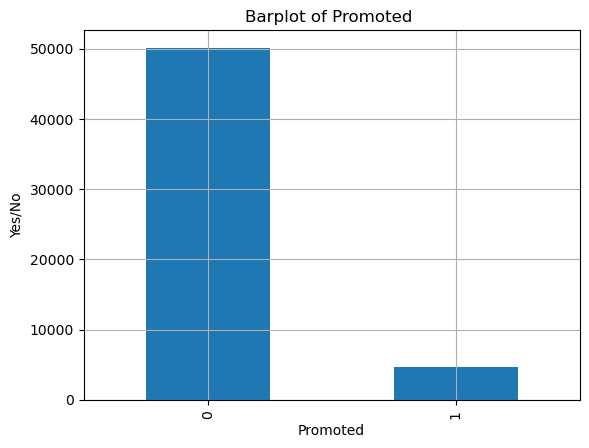

In [4]:
hr_raw.is_promoted.value_counts().plot.bar()
plt.xlabel('Promoted')
plt.ylabel('Yes/No') 
plt.title('Barplot of Promoted ')
plt.grid(True)
plt.show()

In [5]:
hr0 = hr_raw[hr_raw['is_promoted']==0]
hr1 = hr_raw[hr_raw['is_promoted']==1]

hr0_sampled = hr0.sample(n=len(hr1), random_state=1).copy()

hr=pd.concat([hr1,hr0_sampled],axis=0)
hr['is_promoted'].value_counts()

1    4668
0    4668
Name: is_promoted, dtype: int64

In [6]:
# 9k data is enough
hr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9336 entries, 11 to 47320
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   employee_id           9336 non-null   int64  
 1   department            9336 non-null   object 
 2   region                9336 non-null   object 
 3   education             9006 non-null   object 
 4   gender                9336 non-null   object 
 5   recruitment_channel   9336 non-null   object 
 6   no_of_trainings       9336 non-null   int64  
 7   age                   9336 non-null   int64  
 8   previous_year_rating  8625 non-null   float64
 9   length_of_service     9336 non-null   int64  
 10  KPIs_met >80%         9336 non-null   int64  
 11  awards_won?           9336 non-null   int64  
 12  avg_training_score    9336 non-null   int64  
 13  is_promoted           9336 non-null   int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 1.1+ MB


In [7]:
hr.isnull().sum()

employee_id               0
department                0
region                    0
education               330
gender                    0
recruitment_channel       0
no_of_trainings           0
age                       0
previous_year_rating    711
length_of_service         0
KPIs_met >80%             0
awards_won?               0
avg_training_score        0
is_promoted               0
dtype: int64

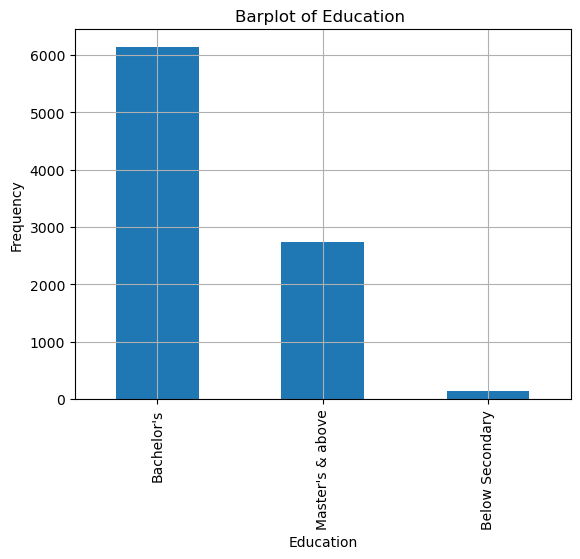

In [8]:
# plotting columns with nulls
hr.education.value_counts().plot.bar()
plt.xlabel('Education')
plt.ylabel('Frequency') 
plt.title('Barplot of Education ')
plt.grid(True)
plt.show()

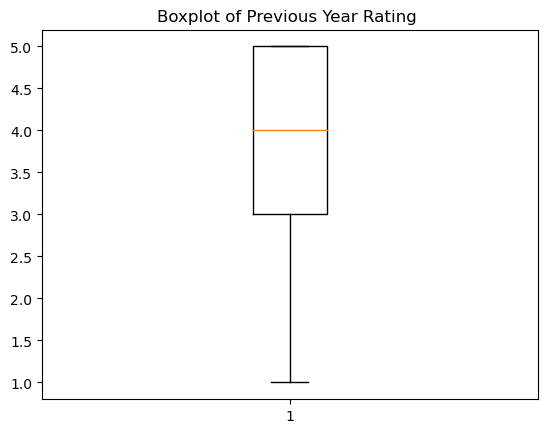

In [9]:
# plotting columns with nulls
plt.boxplot(hr['previous_year_rating'].dropna())
plt.title('Boxplot of Previous Year Rating ')

plt.show()

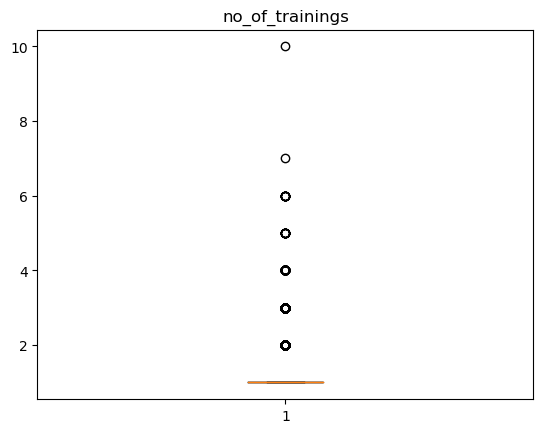

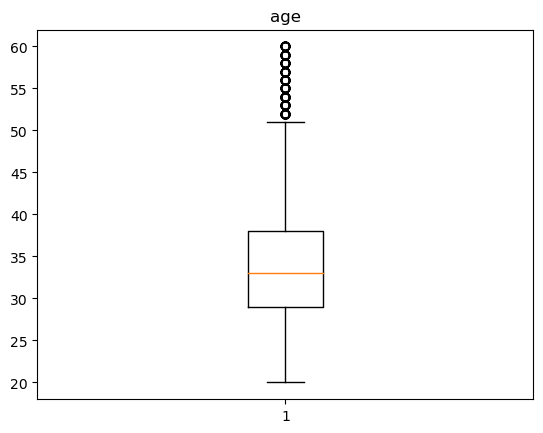

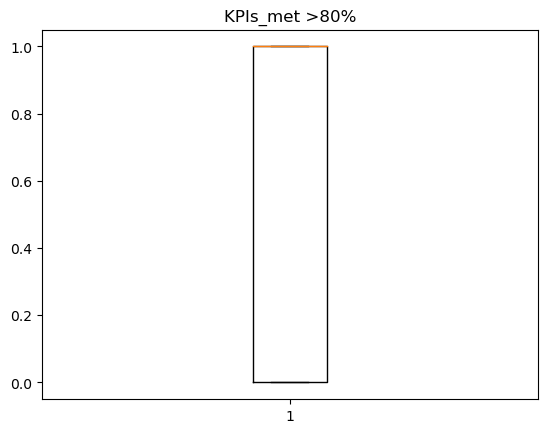

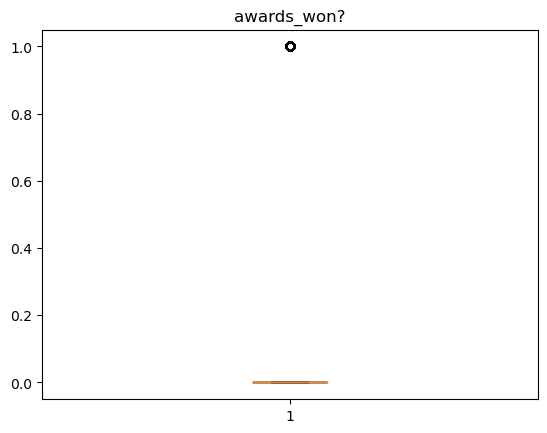

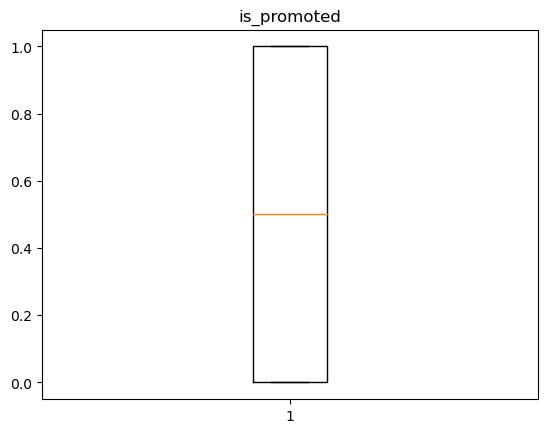

In [10]:
# outlier handling
numerical_features = hr.select_dtypes(include=['int64', 'float64'])

# Create boxplots for each numerical feature
for col in numerical_features:
    plt.boxplot(hr[col])
    plt.title(col)
    plt.show()

C:\Users\Eng Zhen Ye\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


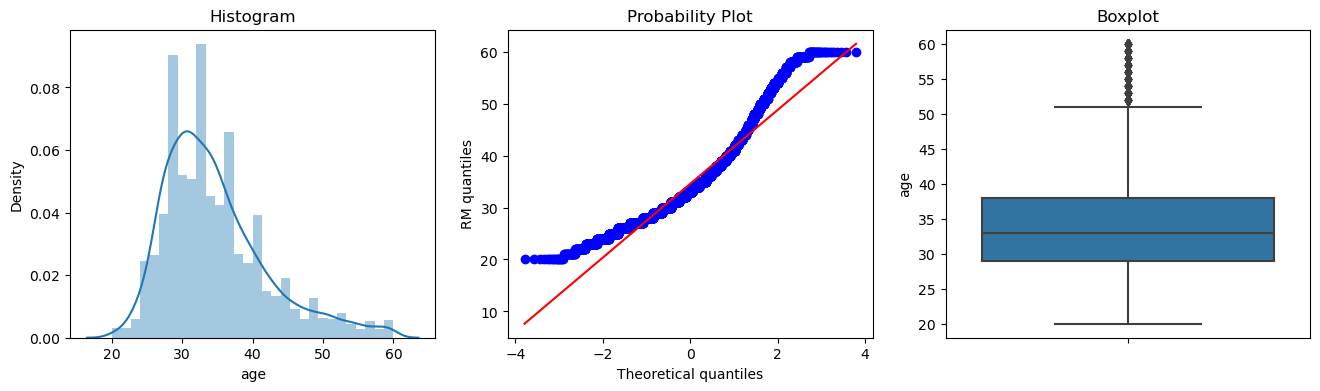

C:\Users\Eng Zhen Ye\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


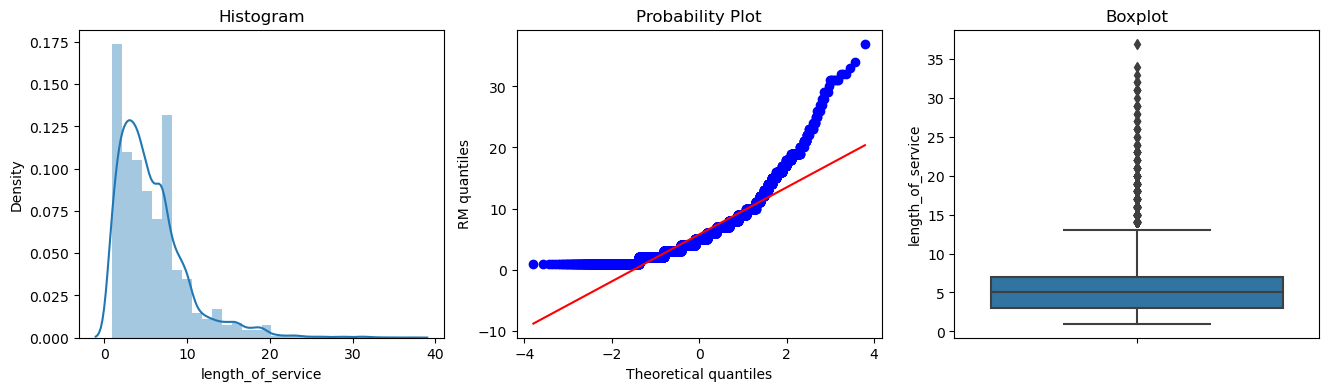

C:\Users\Eng Zhen Ye\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


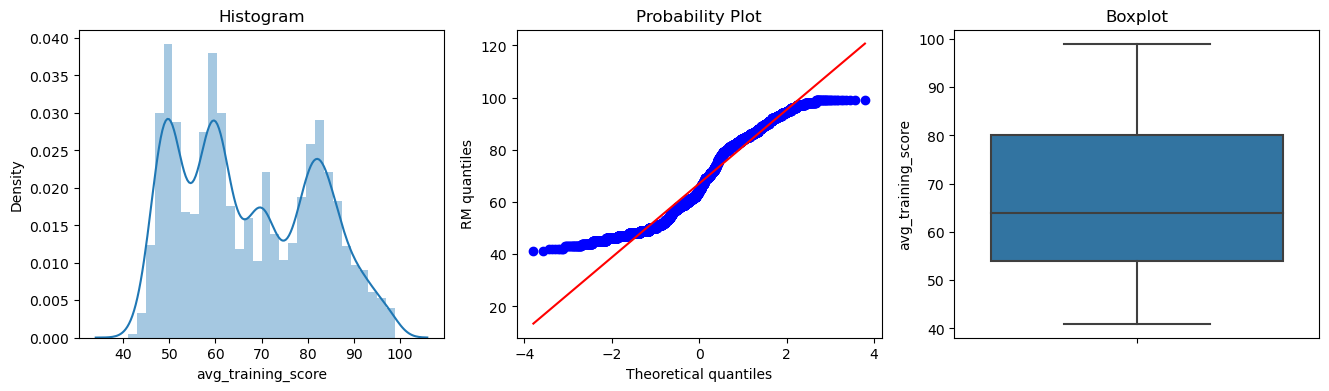

In [11]:
# Q-Q plots for applicable numerical columns
qqplots = ['age', 'length_of_service', 'avg_training_score']

for i in qqplots:
    diagnostic_plots(hr, i)

Chi-square value: 8.559571746470853
P-value: 0.013845626488292717


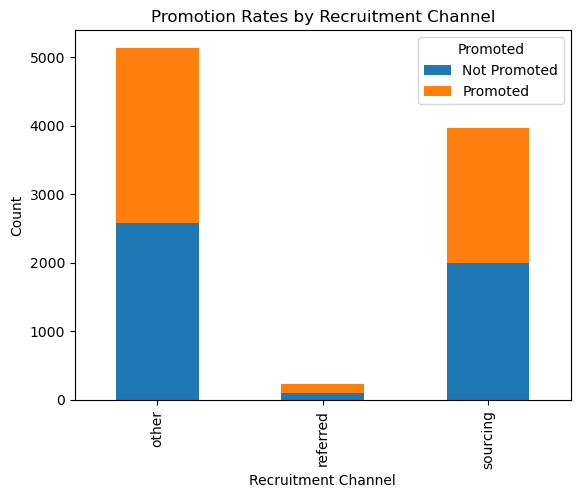

In [12]:
# identifying significance of recruitment channels
from scipy.stats import chi2_contingency
# Create a cross-tabulation
cross_tab = pd.crosstab(hr['recruitment_channel'], hr['is_promoted'])

# Perform chi-square test
chi2, p, _, _ = chi2_contingency(cross_tab)

# Display results
print(f"Chi-square value: {chi2}")
print(f"P-value: {p}")

# Plotting
cross_tab.plot(kind='bar', stacked=True)
plt.title('Promotion Rates by Recruitment Channel')
plt.xlabel('Recruitment Channel')
plt.ylabel('Count')
plt.legend(title='Promoted', labels=['Not Promoted', 'Promoted'])
plt.show()

### 1.2 Cleanse and Transform the data

In [13]:
# Drop the employee_id column
hr.drop('employee_id', axis=1, inplace=True) # cannot identify significance of column when sorted

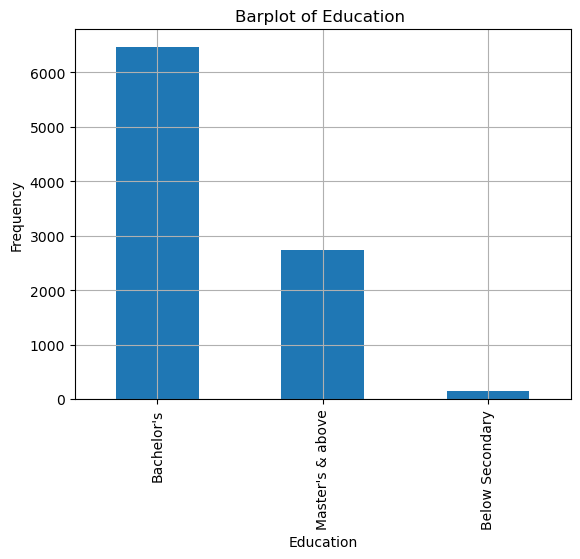

In [14]:
# Replace null values in education with the mode
hr['education'] = hr['education'].fillna(hr['education'].mode()[0])

# Replace null values in previous_year_rating with 0 as the employee could be newly joined
hr['previous_year_rating'] = hr['previous_year_rating'].fillna(0)


hr.education.value_counts().plot.bar()
plt.xlabel('Education')
plt.ylabel('Frequency') 
plt.title('Barplot of Education ')
plt.grid(True)
plt.show()

In [15]:
hr.isnull().sum()

department              0
region                  0
education               0
gender                  0
recruitment_channel     0
no_of_trainings         0
age                     0
previous_year_rating    0
length_of_service       0
KPIs_met >80%           0
awards_won?             0
avg_training_score      0
is_promoted             0
dtype: int64

C:\Users\Eng Zhen Ye\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


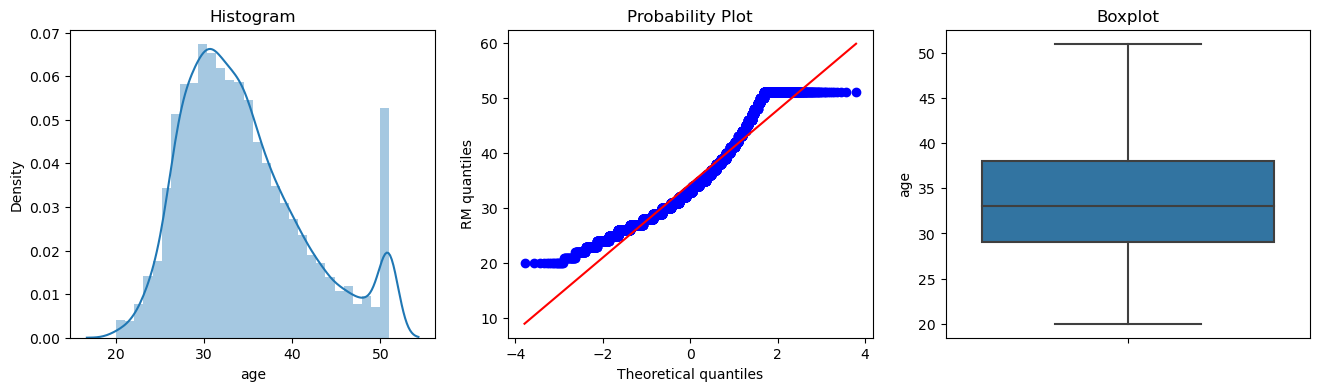

In [16]:
# handling outliers in age
windsorizer = Winsorizer(capping_method ='quantiles', 
                        tail='right', # cap left, right or both tails
                        fold =0.039, # after experimenting with capping methods and folds, this is best
                        variables=['age'])

windsorizer.fit(hr)

hr = windsorizer.transform(hr)

diagnostic_plots(hr, 'age')

In [17]:
# handling outliers in length_of_service through transformation

C:\Users\Eng Zhen Ye\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


C:\Users\Eng Zhen Ye\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


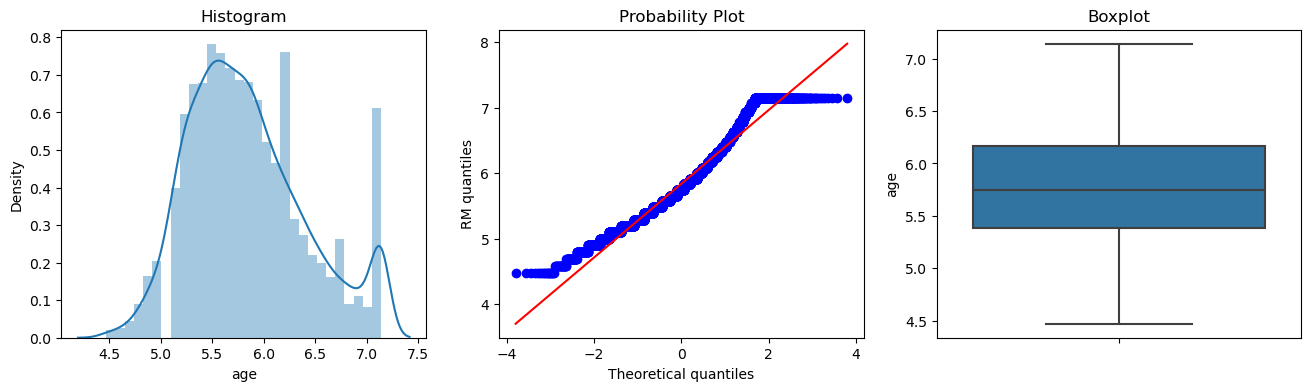

C:\Users\Eng Zhen Ye\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


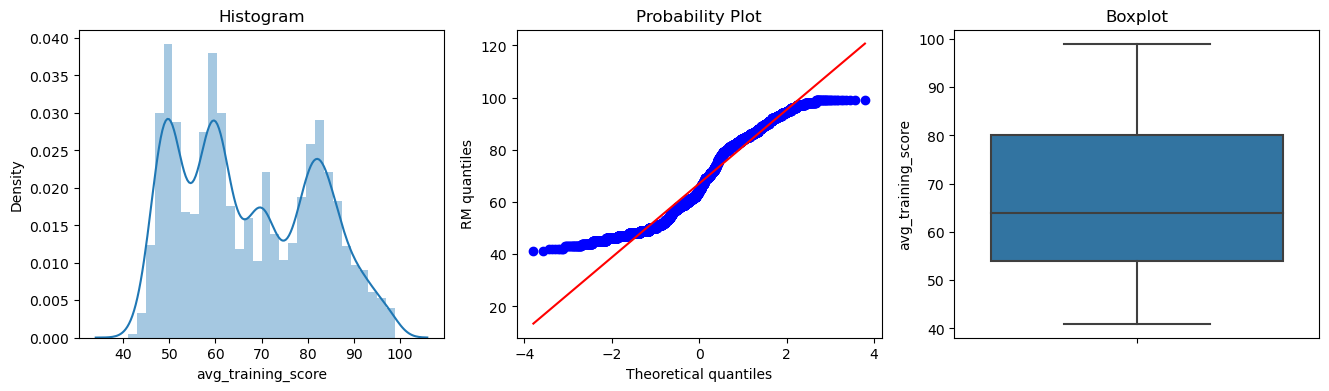

In [18]:
# discretization/transformation
# age (slightly right skewed, might not need), previous_year_rating, avg_training_score (mild)

# LogTransformer 
# initialize the transformer
# lt = LogTransformer(variables=['avg_training_score'])
# fit transformer to data set
# lt.fit(hr)
# transform variables within our data set
# hr = lt.transform(hr)

# # BoxCox Transformer
# bct = BoxCoxTransformer(variables = ['length_of_service'])
# # fit transformer to the data set
# bct.fit(hr)
# hr_t = bct.transform(hr)

# initialize the transformer with a subset of variables to transform
# yjt = YeoJohnsonTransformer(variables = ['avg_training_score'])
# fit transformer to the dataframe
# yjt.fit(hr)
# transform indicated variables
# hr = yjt.transform(hr)

# set up PowerTransformer with the square root exponent
et = PowerTransformer(variables = ['age', 'length_of_service'], exp=1/2) # for sqr root
# fit transformer to data 
et.fit(hr)
hr = et.transform(hr)

# set up PowerTransformer with the cube root exponent
# et = PowerTransformer(variables = ['previous_year_rating'], exp=1/3) # for sqr root
# # fit transformer to data 
# et.fit(hr)
# hr_t = et.transform(hr)

diagnostic_plots(hr, 'length_of_service')
diagnostic_plots(hr, 'age')
diagnostic_plots(hr, 'avg_training_score')


~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 

In [19]:
# encoding of data
# freuency encoding
hr['department'] = hr['department'].map(hr['department'].value_counts(normalize=True))
hr['region'] = hr['region'].map(hr['region'].value_counts(normalize=True))

# label encoding
# from sklearn.preprocessing import LabelEncoder
hr['gender'] = hr['gender'].map( {'f': 0, 'm': 1} ).astype(int)


# ordinal encoding
education_mapping = {
    'Bachelor\'s': 2,
    'Master\'s & above': 1,
    'Below Secondary': 0 }

hr['education'] = hr['education'].map(education_mapping)

# target encoding (used to capture association better)
mean_promotion_by_channel = hr.groupby('recruitment_channel')['is_promoted'].mean()
hr['recruitment_channel'] = hr['recruitment_channel'].map(mean_promotion_by_channel)

#promotion_proportion_by_channel = hr.groupby('recruitment_channel')['is_promoted'].sum() / hr['recruitment_channel'].value_counts()
#hr['recruitment_channel_encoded'] = hr['recruitment_channel'].map(promotion_proportion_by_channel)

In [20]:
hr.head()

department    region  education  gender  recruitment_channel  \
11    0.281598  0.099829          2       0             0.497856   
39    0.281598  0.029456          2       1             0.497856   
60    0.281598  0.040381          1       1             0.497373   
66    0.045094  0.130677          2       1             0.497373   
67    0.281598  0.130677          2       1             0.497856   

    no_of_trainings       age  previous_year_rating  length_of_service  \
11                1  5.916080                   5.0           1.732051   
39                1  5.744563                   5.0           2.449490   
60                1  7.071068                   4.0           4.123106   
66                1  5.196152                   0.0           1.000000   
67                1  5.196152                   0.0           1.000000   

    KPIs_met >80%  awards_won?  avg_training_score  is_promoted  
11              1            0                  50            1  
39              1            0                  51            1  
60              1            0                  47            1  
66              1            1                  58            1  
67              0            0                  61            1

~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 

In [21]:
# normalizing of data
# Split both Inputs (X) and Ouput (y) into training set (70%) and testing set (30%)

# Define Model Inputs (X) and Output (y)
y = hr["is_promoted"]
X = hr.drop('is_promoted',axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

# set up the scaler
scaler = StandardScaler()

# fit the scaler to the train set, it will learn the parameters
scaler.fit(X_train)

# transform train and test sets
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

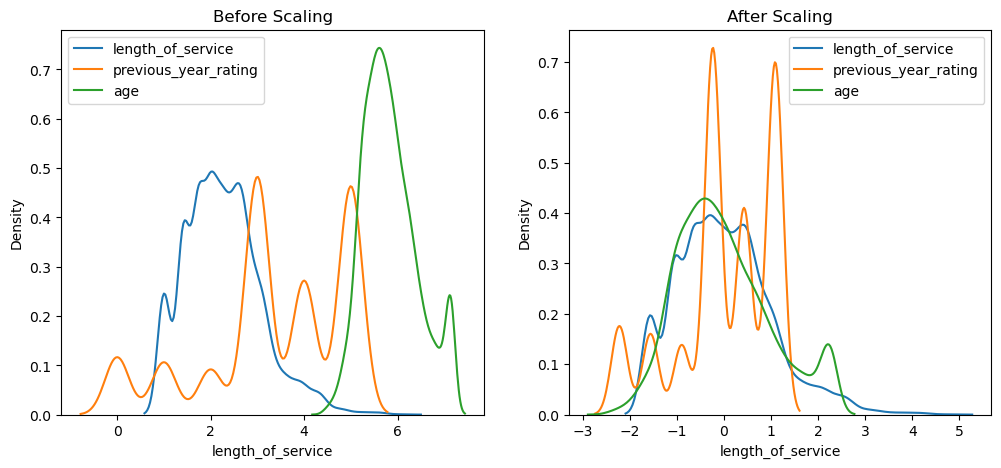

In [22]:
# let's compare the variable distributions before and after scaling
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5))

# before scaling
ax1.set_title('Before Scaling')
sns.kdeplot(X_train['length_of_service'], ax=ax1, label ='length_of_service')
sns.kdeplot(X_train['previous_year_rating'], ax=ax1, label ='previous_year_rating')
sns.kdeplot(X_train['age'], ax=ax1, label ='age')
ax1.legend()

# after scaling
ax2.set_title('After Scaling')
sns.kdeplot(X_train_scaled['length_of_service'], ax=ax2, label ='length_of_service')
sns.kdeplot(X_train_scaled['previous_year_rating'], ax=ax2, label ='previous_year_rating')
sns.kdeplot(X_train_scaled['age'], ax=ax2, label ='age')
ax2.legend()
plt.show()

In [23]:
# The lg model refers to sklearn model and lg2 model refers to statsmodel.api model
# Create the model "lg"
lg = LogisticRegression(solver='lbfgs', # optimization solver
                        max_iter=10000) # maximum iterations: set a big number to make sure the optimization solver will
# run enough iterations to let the model converge

# Fit the model to the training set
lg.fit(X_train_scaled,y_train)

LogisticRegression(max_iter=10000)

In [24]:
print(lg.coef_)
print(lg.intercept_)

[[ 0.6496518   0.16074068 -0.1071554   0.00237824 -0.00742127 -0.1705325
  -0.21214039  0.36090477  0.0423553   0.89049205  0.45259459  1.0829493 ]]
[0.0266031]


In [25]:
# calculated the training accuracy
print(lg.score(X_train_scaled, y_train), '(Train Accuracy)')

0.746442234123948 (Train Accuracy)


In [26]:
# calculated the testing accuracy
print(lg.score(X_test_scaled, y_test), '(Test Accuracy)')

0.7211710103534452 (Test Accuracy)


### 1.3 Correlation Analysis

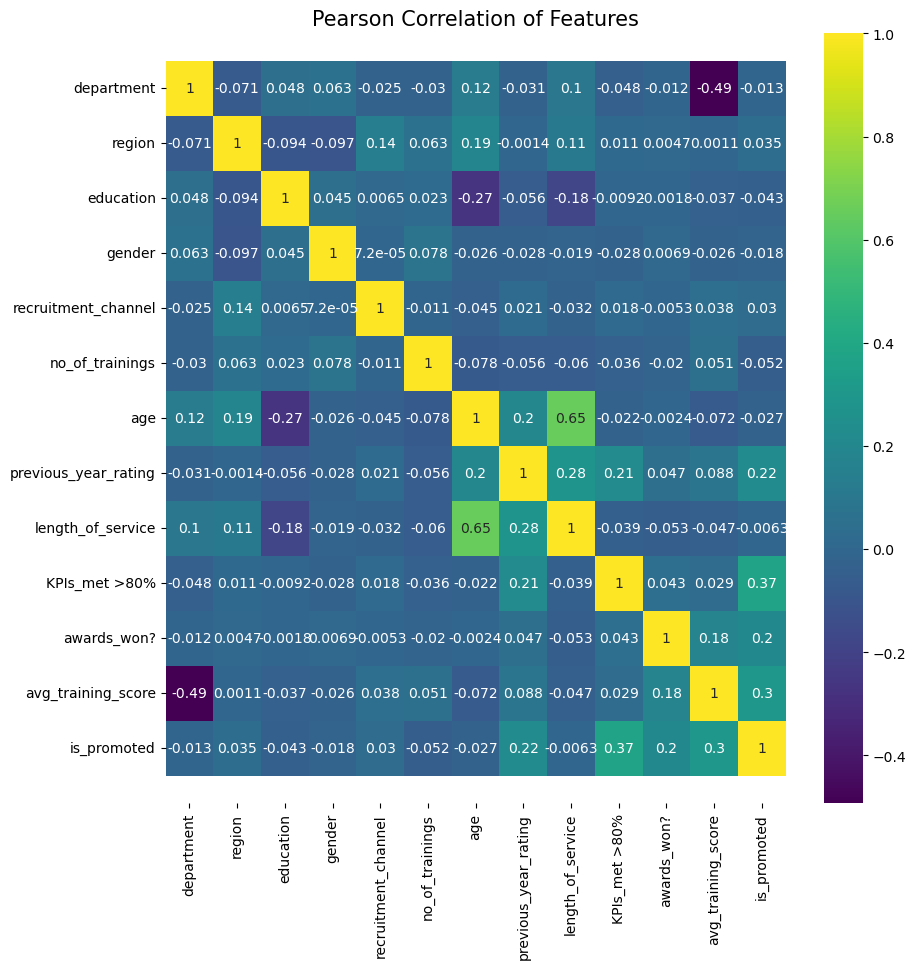

In [27]:
# Heatmap: the correlation between any two features/variables
colormap = plt.cm.viridis
plt.figure(figsize=(10,10))
plt.title('Pearson Correlation of Features', size=15)
ax = sns.heatmap(hr.astype(float).corr(), cmap=colormap, annot=True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

yellow = is promoted
purple = not promoted


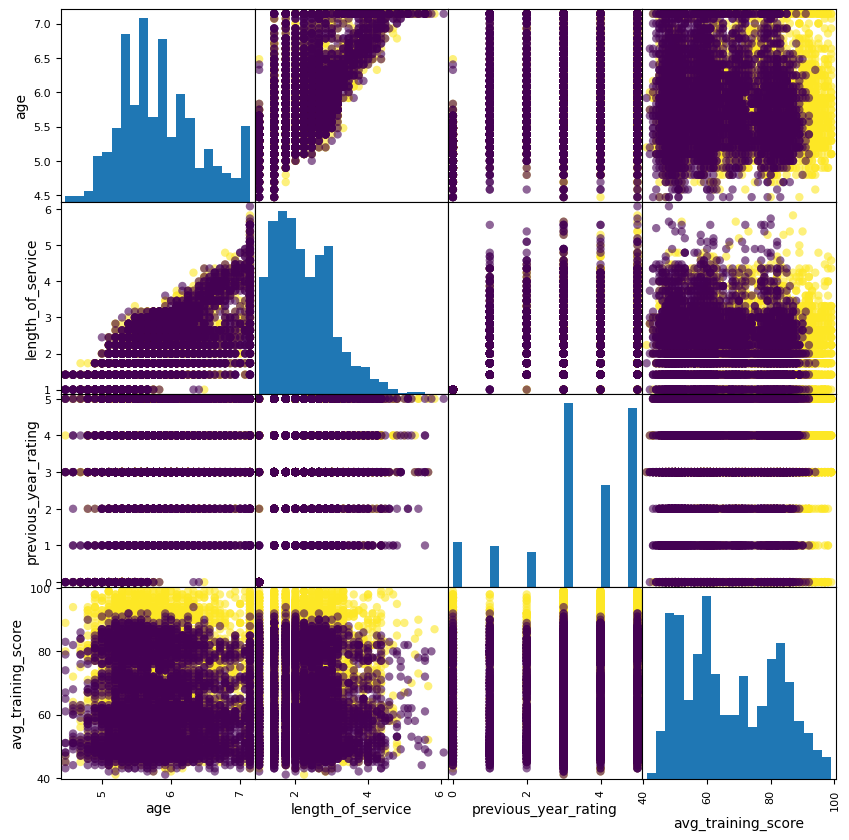

In [28]:
#scatter matrix
from pandas.plotting import scatter_matrix
#sns.set(style="ticks")
#sns.pairplot(hr[['age', 'previous_year_rating', 'length_of_service', 'avg_training_score']])
# Selecting relevant columns for visualization
columns_to_plot = ['age', 'length_of_service', 'previous_year_rating', 'avg_training_score']

# Creating the scatter matrix with color based on 'is_promoted'
scatter_matrix(hr[columns_to_plot], c=hr['is_promoted'], figsize=(10, 10), marker='o', hist_kwds={'bins': 20}, alpha=0.6)

try: 
    plt.colorbar(label='is_promoted')
except:
    print("yellow = is promoted")
    print("purple = not promoted")

# Displaying the plot
plt.show()

#ignore the below error
# yellow = is promoted
# purple = not promoted

### 1.4 Improving the Model

In [29]:
# create a copy for future use
hr_save = hr.copy()

In [30]:
# Create another model lg2 using statsmodel.api: the Logit method and fit function
lg2 = sm.Logit(y_train, X_train_scaled).fit()
# Print out the Model Summary
lg2.summary()

Optimization terminated successfully.
         Current function value: 0.516812
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            is_promoted   No. Observations:                 6535
Model:                          Logit   Df Residuals:                     6523
Method:                           MLE   Df Model:                           11
Date:                Sun, 10 Dec 2023   Pseudo R-squ.:                  0.2544
Time:                        20:27:26   Log-Likelihood:                -3377.4
converged:                       True   LL-Null:                       -4529.7
Covariance Type:            nonrobust   LLR p-value:                     0.000
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
department               0.6534      0.042     15.585      0.000       0.571       0.736
region                   0.1611      0.031      5.162      0.000       0.100       0.222
education               -0.1076      0.031     -3.451      0.001      -0.169      -0.046
gender                   0.0023      0.030      0.076      0.940      -0.057       0.061
recruitment_channel     -0.0075      0.030     -0.252      0.801      -0.066       0.051
no_of_trainings         -0.1713      0.032     -5.303      0.000      -0.235      -0.108
age                     -0.2131      0.042     -5.130      0.000      -0.295      -0.132
previous_year_rating     0.3623      0.032     11.200      0.000       0.299       0.426
length_of_service        0.0425      0.040      1.052      0.293      -0.037       0.122
KPIs_met >80%            0.8925      0.032     28.240      0.000       0.831       0.954
awards_won?              0.4474      0.040     11.213      0.000       0.369       0.526
avg_training_score       1.0859      0.044     24.724      0.000       1.000       1.172
========================================================================================
"""

#### removing outliers in length_of_service

C:\Users\Eng Zhen Ye\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


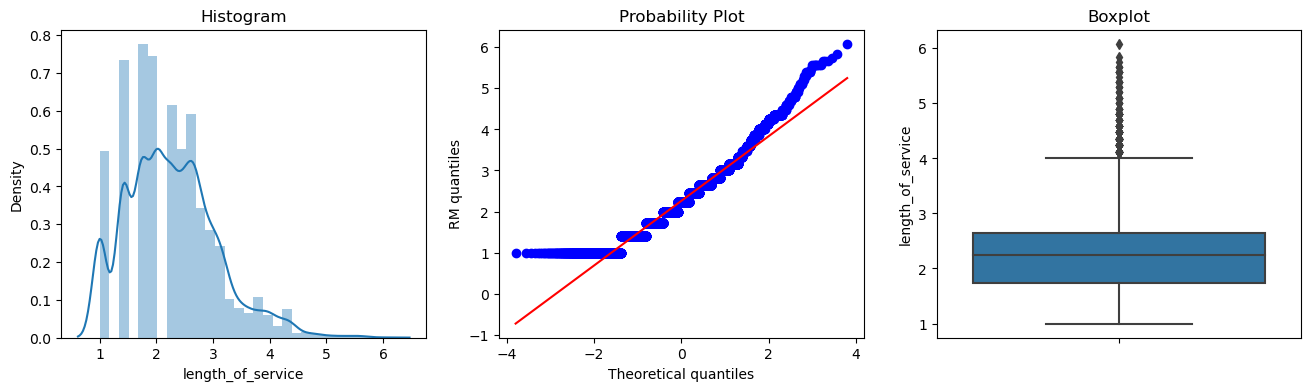

In [31]:
# displaying transformed length_of_service
diagnostic_plots(hr, 'length_of_service')

C:\Users\Eng Zhen Ye\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


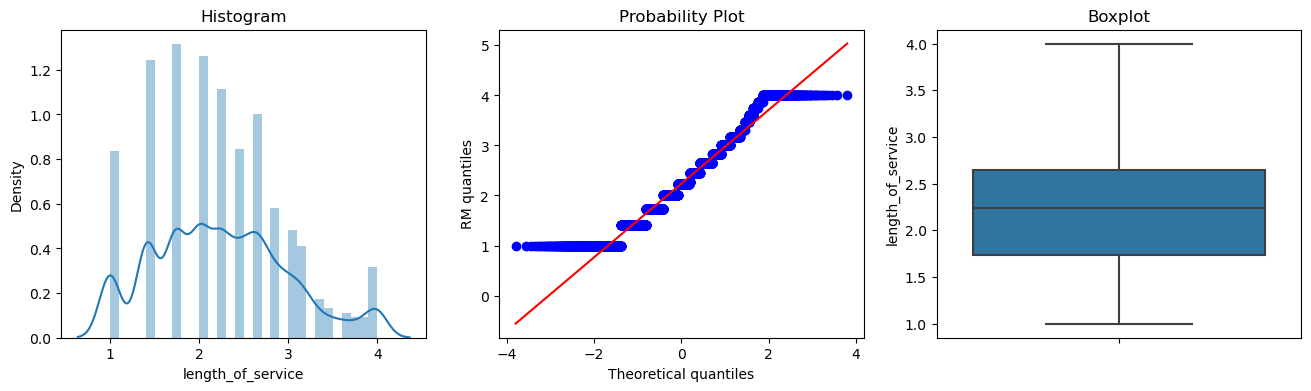

In [32]:
# replacing some outliers by the mean then performing winsorizer 
length_of_service = hr['length_of_service']

# Calculate mean and standard deviation
mean_length_of_service = np.mean(length_of_service)
std_length_of_service = np.std(length_of_service)

# Define the threshold for outliers (for instance, considering values beyond 3 standard deviations as outliers)
threshold = 3 * std_length_of_service

# Replace outliers with the mean value
hr['length_of_service'] = np.where(abs(length_of_service - mean_length_of_service) > threshold,
                                   mean_length_of_service,
                                   length_of_service)

windsorizer = Winsorizer(capping_method ='quantiles', 
                        tail='right', # cap left, right or both tails
                        fold =0.023, # after experimenting with capping methods and folds, this is best
                        variables=['length_of_service'])
windsorizer.fit(hr)
hr = windsorizer.transform(hr)
diagnostic_plots(hr, 'length_of_service')

In [33]:
# Define Model Inputs (X) and Output (y)
y = hr["is_promoted"]
X = hr.drop('is_promoted',axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

# set up the scaler
scaler = StandardScaler()

# fit the scaler to the train set, it will learn the parameters
scaler.fit(X_train)

# transform train and test sets
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

In [34]:
lgi1 = LogisticRegression(solver='lbfgs', # optimization solver
                        max_iter=10000) # maximum iterations: set a big number to make sure the optimization solver will
# run enough iterations to let the model converge

# Fit the model to the training set
lgi1.fit(X_train_scaled,y_train)

LogisticRegression(max_iter=10000)

In [35]:
print(lgi1.coef_)
print(lgi1.intercept_)

[[ 0.6484084   0.16256866 -0.10661696  0.00237196 -0.0075612  -0.17015905
  -0.2262354   0.35510205  0.06930561  0.89284942  0.45441248  1.08306895]]
[0.02673133]


In [36]:
# calculated the training accuracy
print(lgi1.score(X_train_scaled, y_train), '(Train Accuracy)')

0.7476664116296863 (Train Accuracy)


In [37]:
# calculated the testing accuracy
print(lgi1.score(X_test_scaled, y_test), '(Test Accuracy)')

0.7225990717600856 (Test Accuracy)


In [38]:
# Create another model lg3 using statsmodel.api: the Logit method and fit function
lgi1 = sm.Logit(y_train, X_train_scaled).fit()
# Print out the Model Summary
lgi1 .summary()

Optimization terminated successfully.
         Current function value: 0.516656
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            is_promoted   No. Observations:                 6535
Model:                          Logit   Df Residuals:                     6523
Method:                           MLE   Df Model:                           11
Date:                Sun, 10 Dec 2023   Pseudo R-squ.:                  0.2546
Time:                        20:27:27   Log-Likelihood:                -3376.3
converged:                       True   LL-Null:                       -4529.7
Covariance Type:            nonrobust   LLR p-value:                     0.000
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
department               0.6522      0.042     15.550      0.000       0.570       0.734
region                   0.1629      0.031      5.215      0.000       0.102       0.224
education               -0.1071      0.031     -3.433      0.001      -0.168      -0.046
gender                   0.0023      0.030      0.075      0.940      -0.057       0.061
recruitment_channel     -0.0076      0.030     -0.256      0.798      -0.066       0.051
no_of_trainings         -0.1710      0.032     -5.291      0.000      -0.234      -0.108
age                     -0.2272      0.040     -5.647      0.000      -0.306      -0.148
previous_year_rating     0.3565      0.032     10.981      0.000       0.293       0.420
length_of_service        0.0695      0.039      1.774      0.076      -0.007       0.146
KPIs_met >80%            0.8948      0.032     28.276      0.000       0.833       0.957
awards_won?              0.4491      0.040     11.256      0.000       0.371       0.527
avg_training_score       1.0861      0.044     24.724      0.000       1.000       1.172
========================================================================================
"""

In [39]:
# dropping gender and recruitment_channel
hr.drop(columns=['recruitment_channel', 'gender'], inplace=True)

In [40]:
# Define Model Inputs (X) and Output (y)
y = hr["is_promoted"]
X = hr.drop('is_promoted',axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

# set up the scaler
scaler = StandardScaler()

# fit the scaler to the train set, it will learn the parameters
scaler.fit(X_train)

# transform train and test sets
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

In [41]:
lgi2 = LogisticRegression(solver='lbfgs', # optimization solver
                        max_iter=10000) # maximum iterations: set a big number to make sure the optimization solver will
# run enough iterations to let the model converge

# Fit the model to the training set
lgi2.fit(X_train_scaled,y_train)

LogisticRegression(max_iter=10000)

In [42]:
print(lgi2.coef_)
print(lgi2.intercept_)

[[ 0.64815371  0.1612162  -0.10662251 -0.16985559 -0.22583722  0.35469595
   0.0693614   0.89284582  0.45453629  1.08247945]]
[0.02669678]


In [43]:
# calculated the training accuracy
print(lgi2.score(X_train_scaled, y_train), '(Train Accuracy)')

0.7479724560061208 (Train Accuracy)


In [44]:
# calculated the testing accuracy
print(lgi2.score(X_test_scaled, y_test), '(Test Accuracy)')

0.7229560871117459 (Test Accuracy)


In [45]:
# Concatenate scaled features and target variables
train_data = pd.concat([X_train_scaled, y_train.reset_index(drop=True)], axis=1)
test_data = pd.concat([X_test_scaled, y_test.reset_index(drop=True)], axis=1)

# Combine train and test data
hr_export = pd.concat([train_data, test_data], ignore_index=True)

In [46]:
# Create another model lg3 using statsmodel.api: the Logit method and fit function
lg4 = sm.Logit(y_train, X_train_scaled).fit()
# Print out the Model Summary
lg4.summary()

Optimization terminated successfully.
         Current function value: 0.516661
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            is_promoted   No. Observations:                 6535
Model:                          Logit   Df Residuals:                     6525
Method:                           MLE   Df Model:                            9
Date:                Sun, 10 Dec 2023   Pseudo R-squ.:                  0.2546
Time:                        20:27:27   Log-Likelihood:                -3376.4
converged:                       True   LL-Null:                       -4529.7
Covariance Type:            nonrobust   LLR p-value:                     0.000
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
department               0.6519      0.042     15.562      0.000       0.570       0.734
region                   0.1615      0.031      5.253      0.000       0.101       0.222
education               -0.1071      0.031     -3.435      0.001      -0.168      -0.046
no_of_trainings         -0.1707      0.032     -5.305      0.000      -0.234      -0.108
age                     -0.2268      0.040     -5.641      0.000      -0.306      -0.148
previous_year_rating     0.3560      0.032     10.983      0.000       0.293       0.420
length_of_service        0.0695      0.039      1.775      0.076      -0.007       0.146
KPIs_met >80%            0.8948      0.032     28.280      0.000       0.833       0.957
awards_won?              0.4493      0.040     11.263      0.000       0.371       0.527
avg_training_score       1.0855      0.044     24.748      0.000       0.999       1.171
========================================================================================
"""

~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~

In [47]:
# dropping gender and recruitment_channel and length_of_service
hr.drop(columns=['length_of_service'], inplace=True)

In [48]:
# Define Model Inputs (X) and Output (y)
y = hr["is_promoted"]
X = hr.drop('is_promoted',axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

# set up the scaler
scaler = StandardScaler()

# fit the scaler to the train set, it will learn the parameters
scaler.fit(X_train)

# transform train and test sets
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

In [49]:
lgi = LogisticRegression(solver='lbfgs', # optimization solver
                        max_iter=10000) # maximum iterations: set a big number to make sure the optimization solver will
# run enough iterations to let the model converge

# Fit the model to the training set
lgi.fit(X_train_scaled,y_train)

LogisticRegression(max_iter=10000)

In [50]:
print(lgi.coef_)
print(lgi.intercept_)

[[ 0.65052398  0.15895394 -0.10722257 -0.17026461 -0.1854417   0.36763223
   0.88783403  0.44969089  1.08287794]]
[0.02637324]


In [51]:
# calculated the training accuracy
print(lgi.score(X_train_scaled, y_train), '(Train Accuracy)')

0.7475133894414691 (Train Accuracy)


In [52]:
# calculated the testing accuracy
print(lgi.score(X_test_scaled, y_test), '(Test Accuracy)')

0.7218850410567654 (Test Accuracy)


In [53]:
# Create another model lg3 using statsmodel.api: the Logit method and fit function
lg3 = sm.Logit(y_train, X_train_scaled).fit()
# Print out the Model Summary
lg3.summary()

Optimization terminated successfully.
         Current function value: 0.516903
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            is_promoted   No. Observations:                 6535
Model:                          Logit   Df Residuals:                     6526
Method:                           MLE   Df Model:                            8
Date:                Sun, 10 Dec 2023   Pseudo R-squ.:                  0.2543
Time:                        20:27:27   Log-Likelihood:                -3378.0
converged:                       True   LL-Null:                       -4529.7
Covariance Type:            nonrobust   LLR p-value:                     0.000
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
department               0.6543      0.042     15.634      0.000       0.572       0.736
region                   0.1593      0.031      5.187      0.000       0.099       0.219
education               -0.1077      0.031     -3.454      0.001      -0.169      -0.047
no_of_trainings         -0.1711      0.032     -5.321      0.000      -0.234      -0.108
age                     -0.1863      0.033     -5.641      0.000      -0.251      -0.122
previous_year_rating     0.3690      0.032     11.684      0.000       0.307       0.431
KPIs_met >80%            0.8898      0.031     28.267      0.000       0.828       0.951
awards_won?              0.4445      0.040     11.176      0.000       0.367       0.522
avg_training_score       1.0859      0.044     24.764      0.000       1.000       1.172
========================================================================================
"""

#### experiment with PCA

In [54]:
from sklearn.decomposition import PCA

# Define Model Inputs (X) and Output (y)
y = hr_save["is_promoted"]
X = hr_save.drop('is_promoted',axis=1)

# set up the PCA
pca = PCA()

# set up the scaler
scaler = StandardScaler()

# fit the scaler to the train set, it will learn the parameters
scaler.fit(X)

# transform train and test sets
X_scaled = scaler.transform(X)

pca.fit(X_scaled)
X_new = pca.transform(X_scaled)


In [55]:
plt.plot(pca.explained_variance_ratio_, linewidth=2)
plt.title('Percentage of Variance Explained')
plt.xlabel('Index Number of Components')
plt.ylabel('Percentage of Variance Explained')

Text(0, 0.5, 'Percentage of Variance Explained')

In [56]:
# show the variance explanation for each Principal Component
print(len(pca.explained_variance_ratio_))
print(pca.explained_variance_ratio_)


12
[0.16602575 0.13327516 0.10013068 0.09294817 0.08751351 0.08249556
 0.07854997 0.07384971 0.06580305 0.05368878 0.03859041 0.02712923]


In [57]:
# Explained variance ratios obtained from PCA
explained_variance_ratios = np.array([0.16602575, 0.13327516, 0.10013068, 0.09294817, 0.08751351, 0.08249556,
 0.07854997, 0.07384971, 0.06580305, 0.05368878, 0.03859041, 0.02712923])

# Find the number of components that contribute to 90% of variance
cumulative_variance = np.cumsum(explained_variance_ratios)
n_components = np.argmax(cumulative_variance >= 0.9) + 1  # Adding 1 to start indexing from 1

print(f"Number of components contributing to 90% variance: {n_components}")

Number of components contributing to 90% variance: 10


In [58]:
X_new = pd.DataFrame(X_new, columns=X.columns, index=X.index)

X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.3, random_state=1)

# set up the scaler
scaler = StandardScaler()

# fit the scaler to the train set, it will learn the parameters
scaler.fit(X_train)

# transform train and test sets
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

In [59]:
lgp = LogisticRegression(solver='lbfgs', # optimization solver
                        max_iter=10000) # maximum iterations: set a big number to make sure the optimization solver will
# run enough iterations to let the model converge

# Fit the model to the training set
lgp.fit(X_train_scaled,y_train)

LogisticRegression(max_iter=10000)

In [60]:
print(lgp.coef_)
print(lgp.intercept_)

[[ 0.08511185  0.89029811 -0.81803398  0.28215714  0.2942884   0.32350625
   0.32250823  0.18667076 -0.05197887 -0.10688393 -0.7727608  -0.14051069]]
[0.02654156]


In [61]:
# calculated the training accuracy
print(lgp.score(X_train_scaled, y_train), '(Train Accuracy)')

0.746442234123948 (Train Accuracy)


In [62]:
# calculated the testing accuracy
print(lgp.score(X_test_scaled, y_test), '(Test Accuracy)')

0.7211710103534452 (Test Accuracy)


### 1.5 Export the data

In [63]:
hr_export.to_csv('C:/Users/Eng Zhen Ye/ML/asg 1/hr_export.csv', index=False)

## 2. Airbnb

### 2.1 Load and Explore the data

In [64]:
lis_raw = pd.read_csv('listings.csv')

# filter lis into a specific something (region?, )

lis_raw.head()

id                                 name  host_id  host_name  \
0  49091    COZICOMFORT LONG TERM STAY ROOM 2   266763  Francesca   
1  50646      Pleasant Room along Bukit Timah   227796    Sujatha   
2  56334                          COZICOMFORT   266763  Francesca   
3  71609  Ensuite Room (Room 1 & 2) near EXPO   367042    Belinda   
4  71896      B&B  Room 1 near Airport & EXPO   367042    Belinda   

  neighbourhood_group neighbourhood  latitude  longitude     room_type  price  \
0        North Region     Woodlands   1.44255  103.79580  Private room     83   
1      Central Region   Bukit Timah   1.33235  103.78521  Private room     81   
2        North Region     Woodlands   1.44246  103.79667  Private room     69   
3         East Region      Tampines   1.34541  103.95712  Private room    206   
4         East Region      Tampines   1.34567  103.95963  Private room     94   

   minimum_nights  number_of_reviews last_review  reviews_per_month  \
0             180                  1  2013-10-21               0.01   
1              90                 18  2014-12-26               0.28   
2               6                 20  2015-10-01               0.20   
3               1                 14  2019-08-11               0.15   
4               1                 22  2019-07-28               0.22   

   calculated_host_listings_count  availability_365  
0                               2               365  
1                               1               365  
2                               2               365  
3                               9               353  
4                               9               355

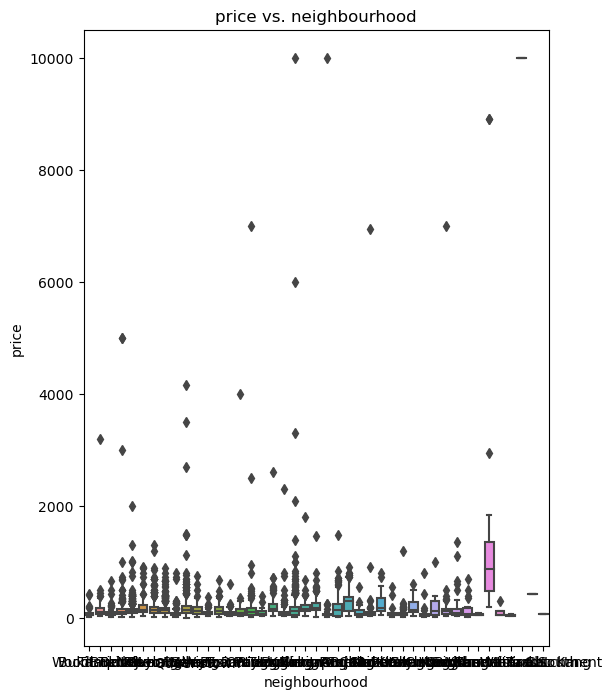

In [65]:
# visualize price between neighbourhoods
plt.figure(figsize=(6,8))
sns.boxplot(y='price', x='neighbourhood', data=lis_raw)
plt.title('price vs. neighbourhood')
plt.show()

In [66]:
# visualize price between neighbourhood_group
plt.figure(figsize=(6,8))
sns.boxplot(y='price', x='neighbourhood_group', data=lis_raw)
plt.title('price vs. neighbourhood_group')
plt.show()

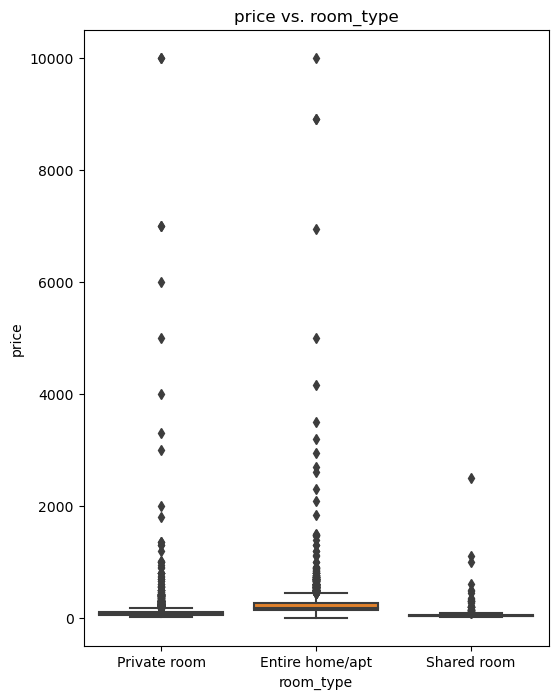

In [67]:
# visualize price between room_type
plt.figure(figsize=(6,8))
sns.boxplot(y='price', x='room_type', data=lis_raw)
plt.title('price vs. room_type')
plt.show()

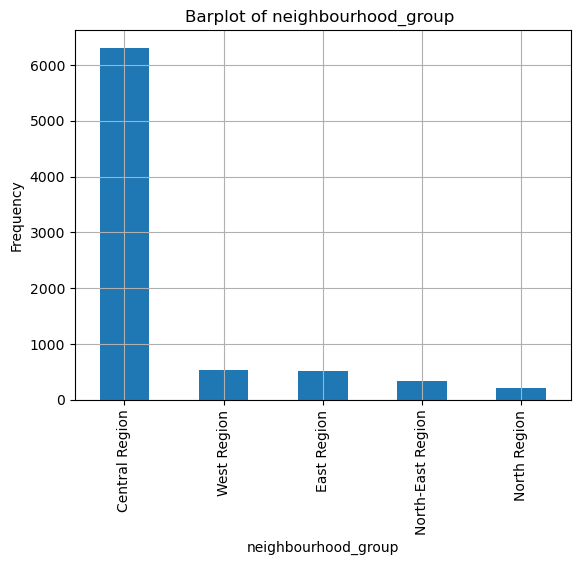

In [68]:
# visualize neighbourhood_group
lis_raw.neighbourhood_group.value_counts().plot.bar()
plt.xlabel('neighbourhood_group')
plt.ylabel('Frequency') 
plt.title('Barplot of neighbourhood_group ')
plt.grid(True)
plt.show()

In [69]:
# filtering dataset to only consist of listings in Central Region
# lis = lis[lis['neighbourhood_group'] == 'Central Region']

# columns_to_drop = ['room_type', 'neighbourhood_group']
# lis.drop(columns=columns_to_drop, inplace=True)

lis = lis_raw.copy()

In [70]:
lis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7907 entries, 0 to 7906
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              7907 non-null   int64  
 1   name                            7905 non-null   object 
 2   host_id                         7907 non-null   int64  
 3   host_name                       7907 non-null   object 
 4   neighbourhood_group             7907 non-null   object 
 5   neighbourhood                   7907 non-null   object 
 6   latitude                        7907 non-null   float64
 7   longitude                       7907 non-null   float64
 8   room_type                       7907 non-null   object 
 9   price                           7907 non-null   int64  
 10  minimum_nights                  7907 non-null   int64  
 11  number_of_reviews               7907 non-null   int64  
 12  last_review                     51

In [71]:
lis.isnull().sum()

id                                   0
name                                 2
host_id                              0
host_name                            0
neighbourhood_group                  0
neighbourhood                        0
latitude                             0
longitude                            0
room_type                            0
price                                0
minimum_nights                       0
number_of_reviews                    0
last_review                       2758
reviews_per_month                 2758
calculated_host_listings_count       0
availability_365                     0
dtype: int64

In [72]:
# unable to identify significance of this feature
lis.drop('name', axis=1, inplace=True)

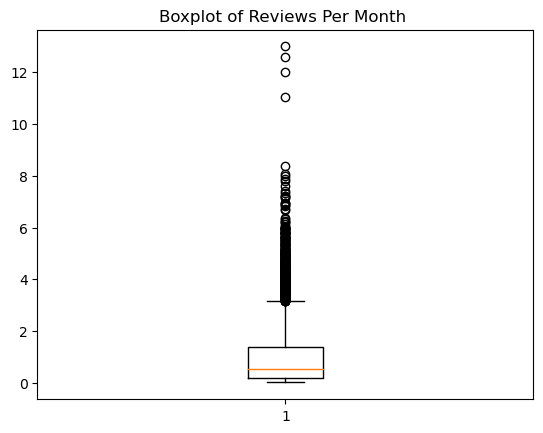

In [73]:
# plotting columns with nulls
plt.boxplot(lis['reviews_per_month'].dropna())
plt.title('Boxplot of Reviews Per Month ')

plt.show()

In [74]:
# Convert the list to a pandas Series
data = pd.Series(lis['reviews_per_month'])

# Get descriptive statistics
descriptive_stats = data.describe()

print(descriptive_stats)

count    5149.000000
mean        1.043669
std         1.285851
min         0.010000
25%         0.180000
50%         0.550000
75%         1.370000
max        13.000000
Name: reviews_per_month, dtype: float64


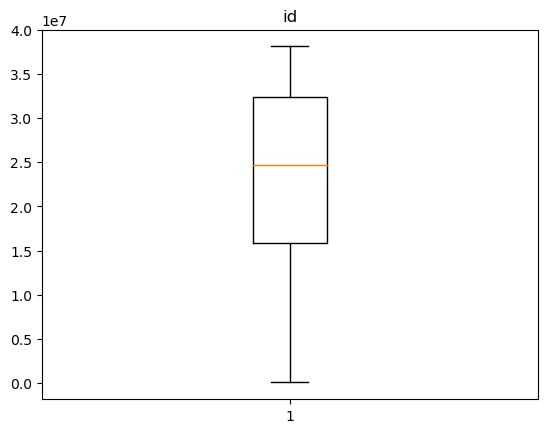

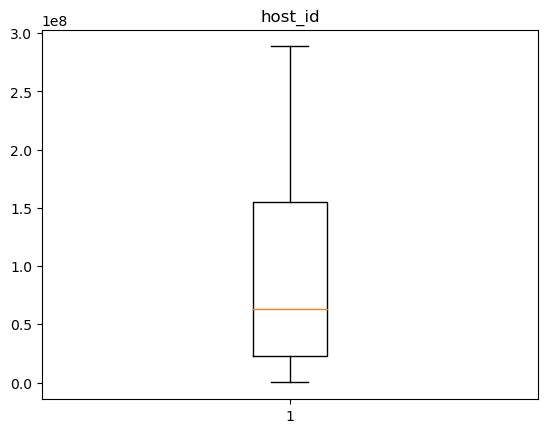

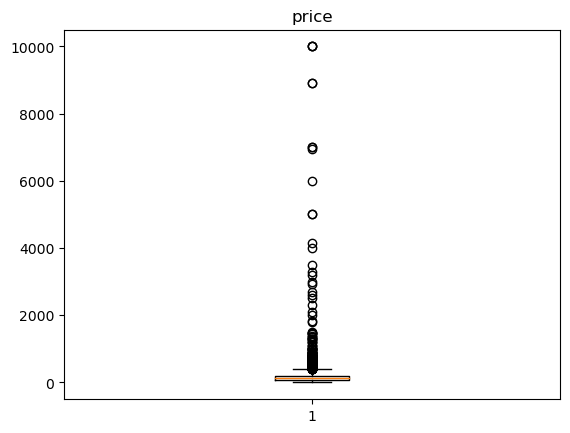

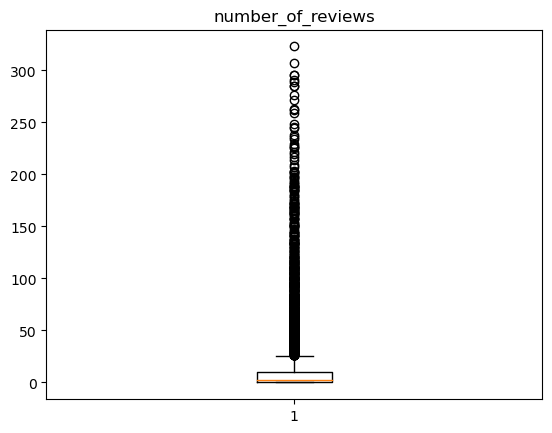

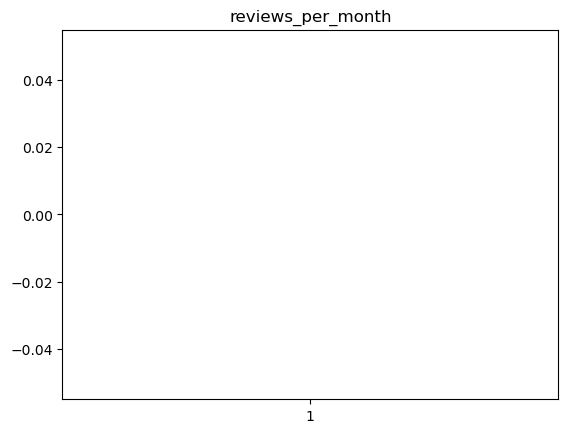

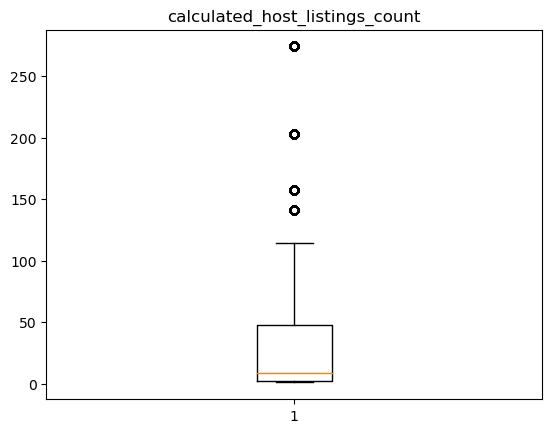

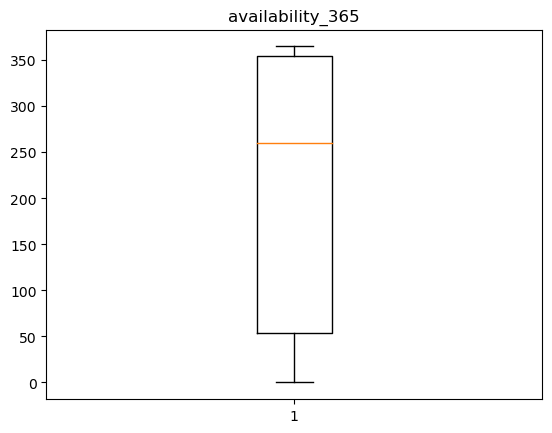

In [75]:
# outlier handling
numerical_features = lis.select_dtypes(include=['int64', 'float64'])

# Create boxplots for each numerical feature
for col in numerical_features:
    plt.boxplot(lis[col])
    plt.title(col)
    plt.show()

C:\Users\Eng Zhen Ye\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


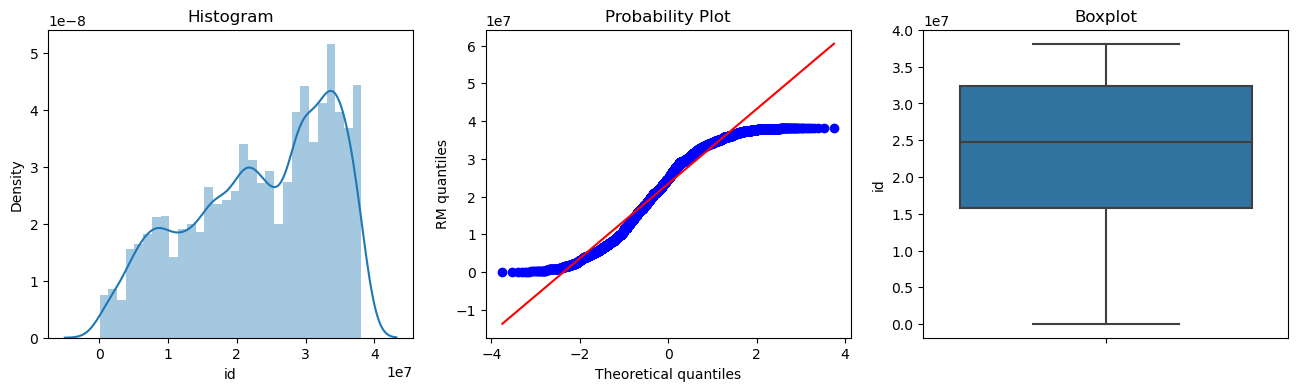

C:\Users\Eng Zhen Ye\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


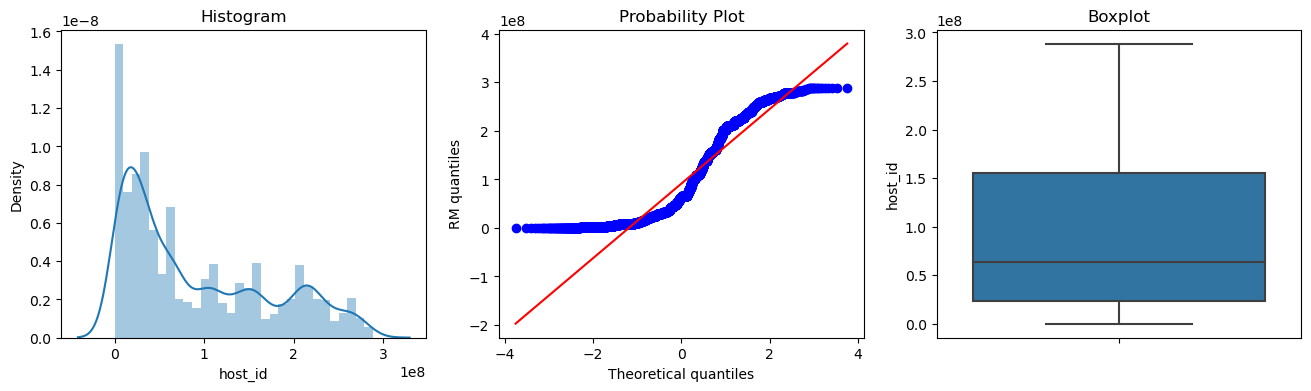

C:\Users\Eng Zhen Ye\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


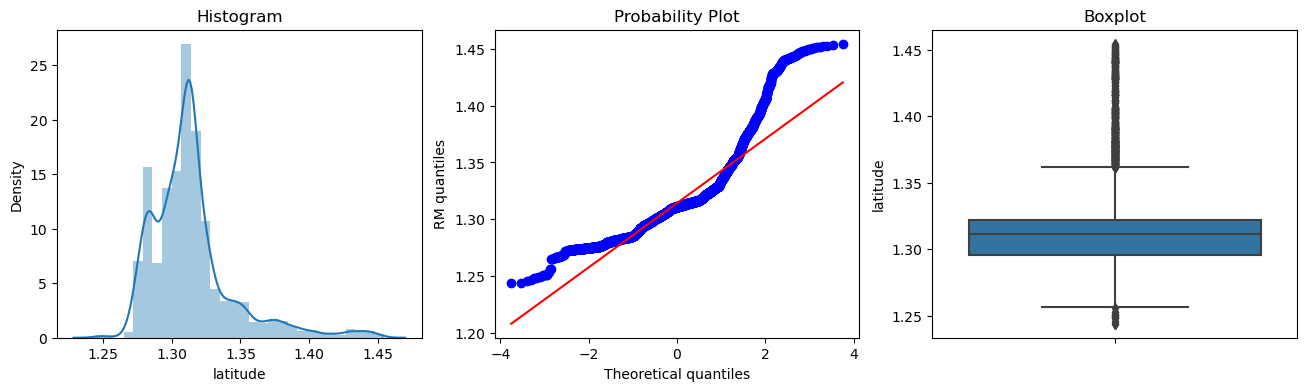

C:\Users\Eng Zhen Ye\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


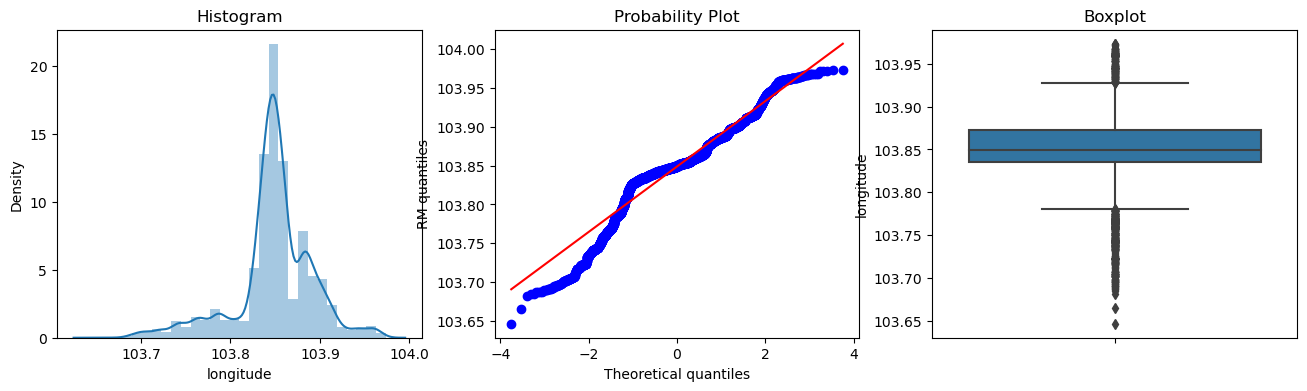

C:\Users\Eng Zhen Ye\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


C:\Users\Eng Zhen Ye\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


C:\Users\Eng Zhen Ye\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


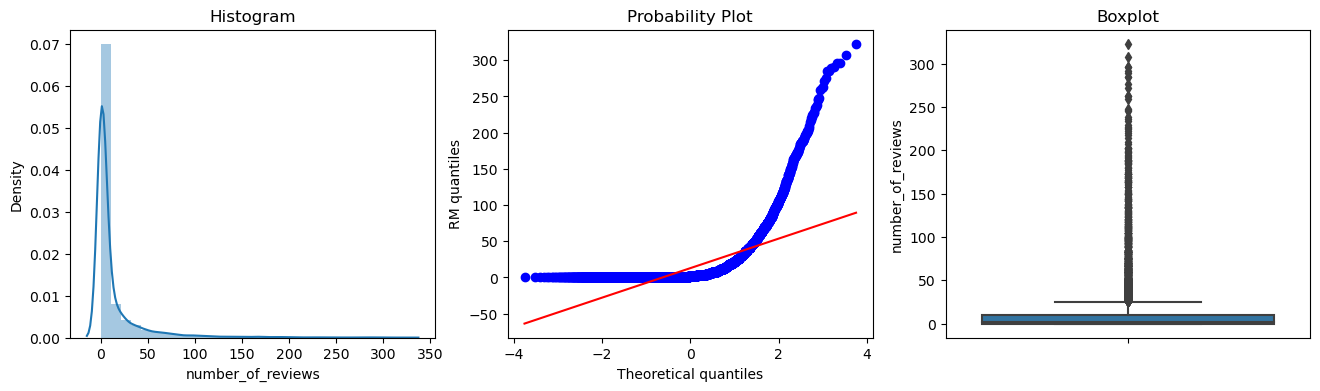

C:\Users\Eng Zhen Ye\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


C:\Users\Eng Zhen Ye\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


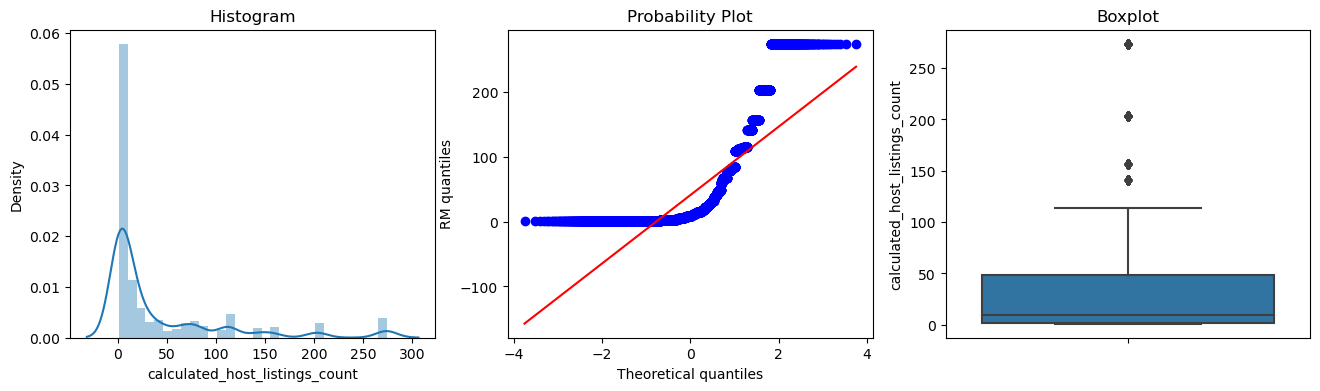

C:\Users\Eng Zhen Ye\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


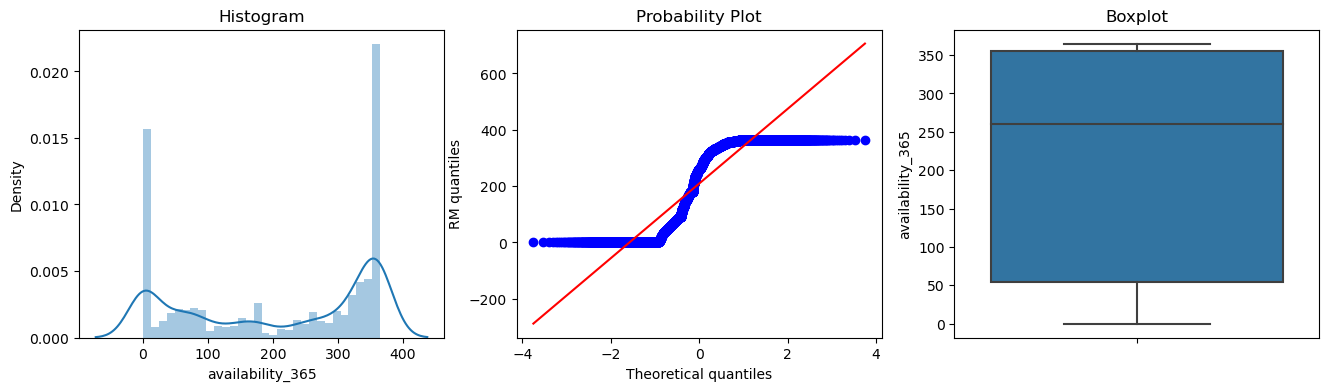

In [76]:
# Q-Q plots for applicable numerical columns
for i in numerical_features:
    diagnostic_plots(lis, i)

Not Rare Host Names:
Jay         290
Alvin       249
Richards    157
Aaron       145
Rain        115
Darcy       114
Kaurus      112
RedDoorz    109
Alex        105
Joey         94
Name: host_name, dtype: int64


C:\Users\Eng Zhen Ye\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 38745 (\N{CJK UNIFIED IDEOGRAPH-9759}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Eng Zhen Ye\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 65404 (\N{HALFWIDTH KATAKANA LETTER SI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Eng Zhen Ye\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 65437 (\N{HALFWIDTH KATAKANA LETTER N}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Eng Zhen Ye\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 29747 (\N{CJK UNIFIED IDEOGRAPH-7433}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Eng Zhen Ye\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py

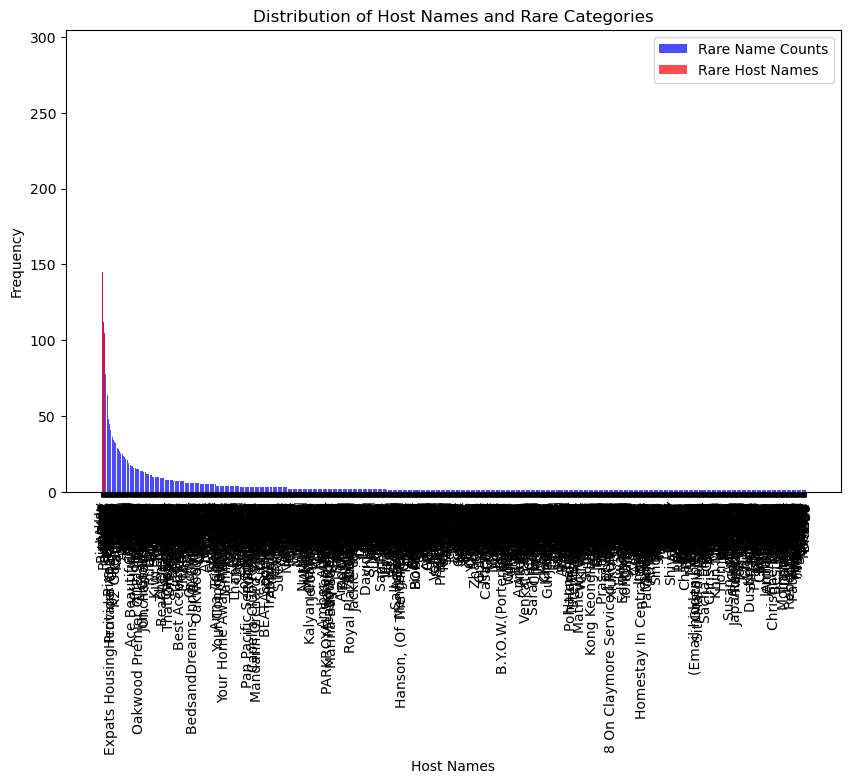

In [77]:
# rare categories in host_name
total_records = len(lis)
threshold_percentage = 1  # Define the threshold percentage of 1%

# Count occurrences of each host name
host_name_counts = lis['host_name'].value_counts()

# Calculate the threshold count
threshold_count = total_records * (threshold_percentage / 100)

# Filter host names that occur less than the threshold count
rare_host_names = host_name_counts[host_name_counts > threshold_count]

# Display the rare categories
print("Not Rare Host Names:")
print(rare_host_names)

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(host_name_counts.index, host_name_counts.values, color='blue', alpha=0.7, label='Rare Name Counts')
plt.bar(rare_host_names.index, rare_host_names.values, color='red', alpha=0.7, label='Rare Host Names')

plt.xlabel('Host Names')
plt.ylabel('Frequency')
plt.title('Distribution of Host Names and Rare Categories')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.legend()

plt.show()

### 2.2 Cleanse and Transform the data

In [78]:
# handling nulls

# last_review, splitting of day, month, year. if null all values == 0
lis['last_review'] = pd.to_datetime(lis['last_review'])
lis['day'] = lis['last_review'].dt.day
lis['month'] = lis['last_review'].dt.month
lis['year'] = lis['last_review'].dt.year

# impute nulls in day, month, year
lis['day'] = lis['day'].fillna(0)
lis['month'] = lis['month'].fillna(0)
lis['year'] = lis['year'].fillna(0)

# reviews_per_month, just imputing with 0
lis['reviews_per_month'] = lis['reviews_per_month'].fillna(0)

# feature engineering with last_review before removing last_review


# drop the last_review column
lis.drop('last_review', axis=1, inplace=True)

# removing clear outlier 
lis = lis[lis['price'] <= 8000]
print(len(lis))

7902


In [79]:
lis.isnull().sum()

id                                0
host_id                           0
host_name                         0
neighbourhood_group               0
neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
day                               0
month                             0
year                              0
dtype: int64

~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 

C:\Users\Eng Zhen Ye\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


C:\Users\Eng Zhen Ye\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


C:\Users\Eng Zhen Ye\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


C:\Users\Eng Zhen Ye\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


C:\Users\Eng Zhen Ye\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


C:\Users\Eng Zhen Ye\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


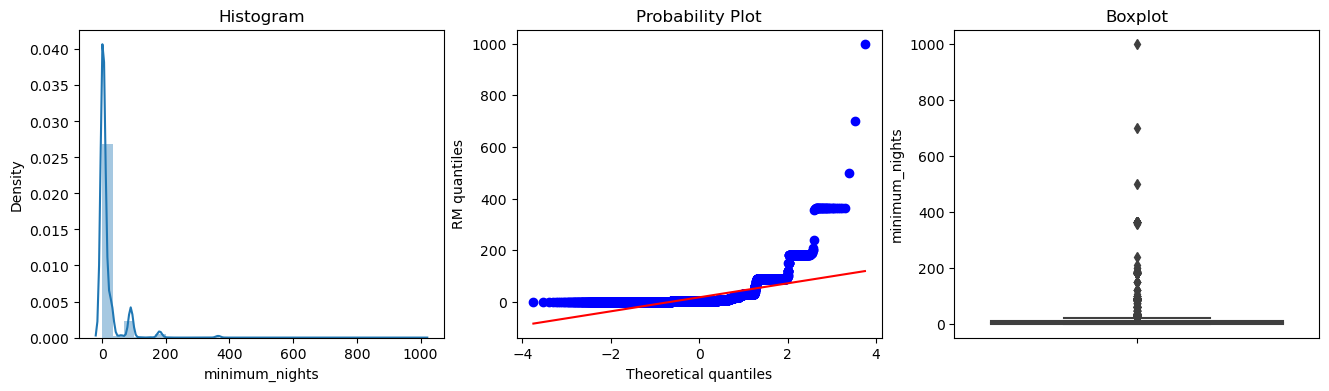

C:\Users\Eng Zhen Ye\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


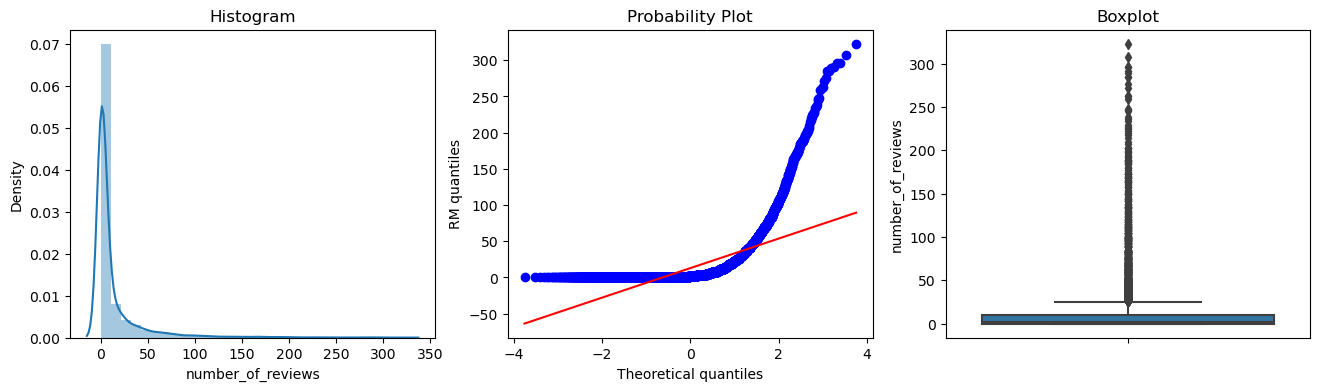

C:\Users\Eng Zhen Ye\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


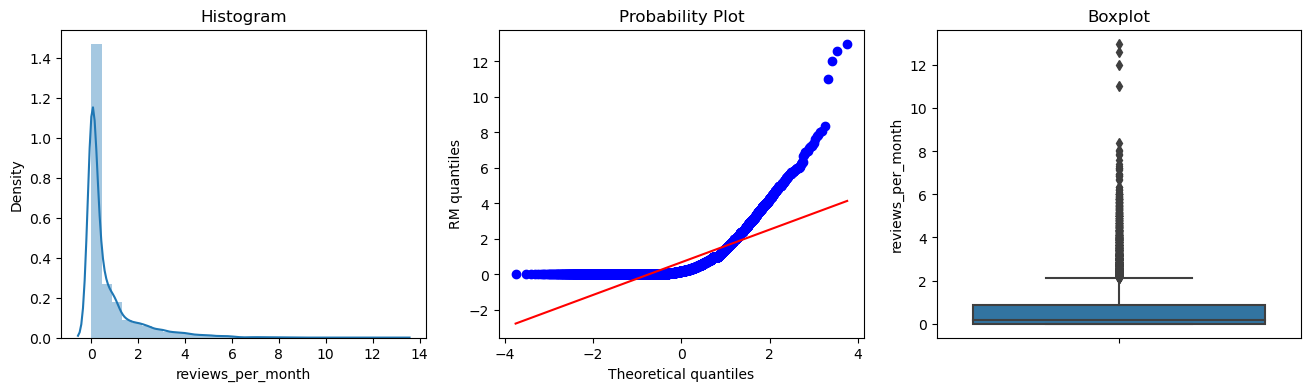

C:\Users\Eng Zhen Ye\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


C:\Users\Eng Zhen Ye\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


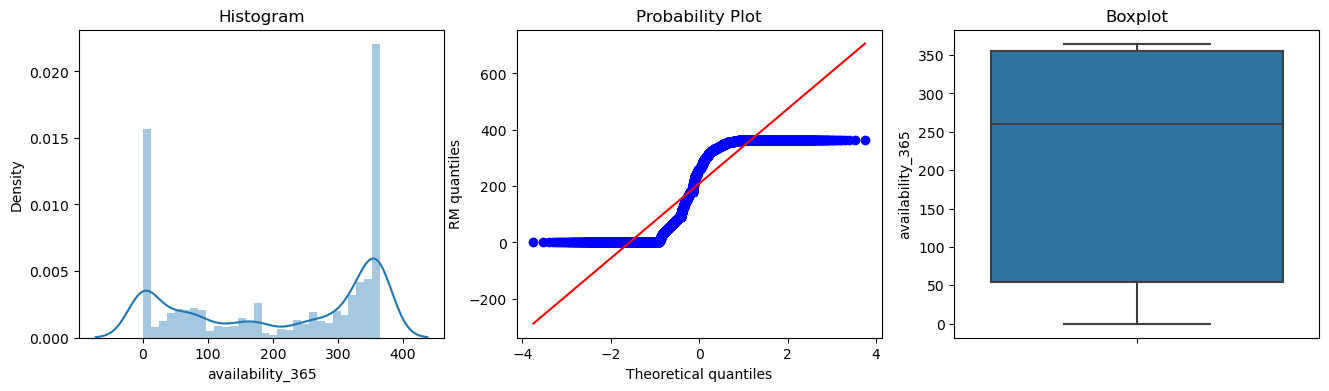

C:\Users\Eng Zhen Ye\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


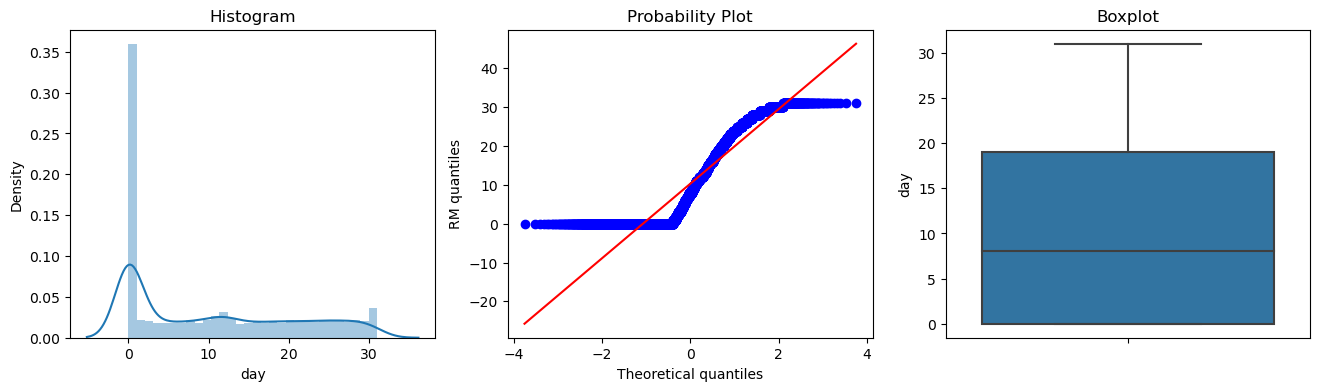

C:\Users\Eng Zhen Ye\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


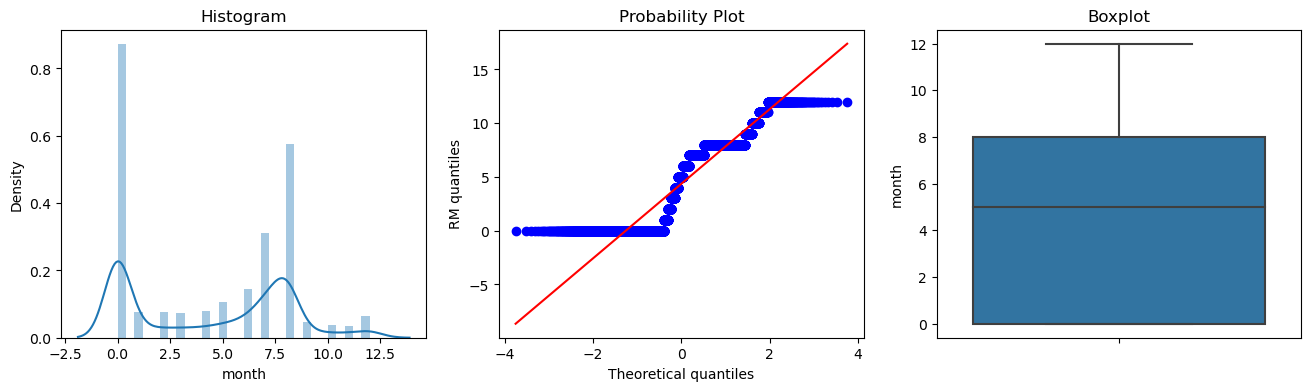

C:\Users\Eng Zhen Ye\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


In [80]:
# exploring distribution of numerical features again
numerical_features = lis.select_dtypes(include=['int64', 'float64'])

# Q-Q plots for applicable numerical columns
for i in numerical_features:
    diagnostic_plots(lis, i)

C:\Users\Eng Zhen Ye\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


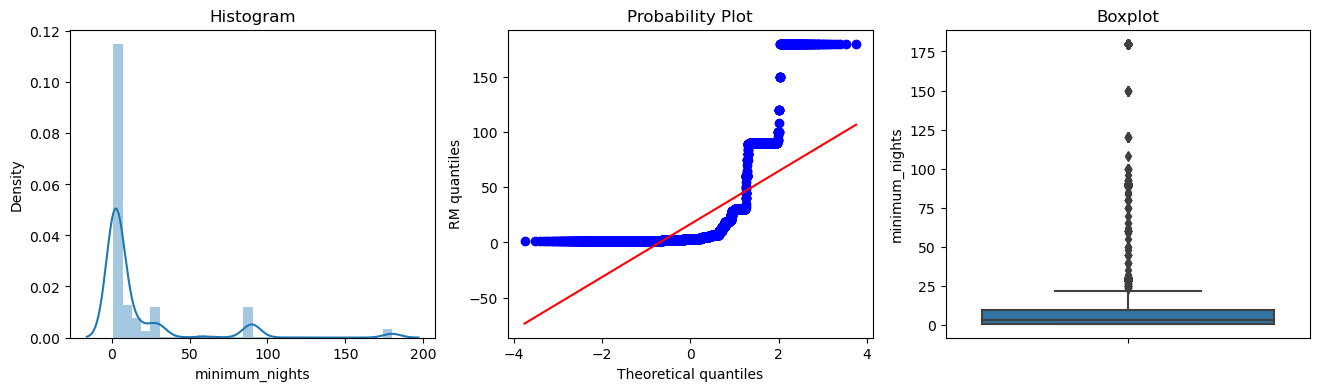

In [81]:
# trimming of distant outliers before transforming
windsorizer = Winsorizer(capping_method ='quantiles', 
                        tail='right', # cap left, right or both tails
                        fold =0.01, # after experimenting with capping methods and folds, this is best
                        variables=['minimum_nights'])

windsorizer.fit(lis)
lis = windsorizer.transform(lis)
diagnostic_plots(lis, 'minimum_nights')

In [82]:
# trimming of distant outliers before transforming
windsorizer = Winsorizer(capping_method ='quantiles', 
                        tail='right', # cap left, right or both tails
                        fold =0.07, # after experimenting with capping methods and folds, this is best
                        variables=['calculated_host_listings_count'])

windsorizer.fit(lis)
lis = windsorizer.transform(lis)
diagnostic_plots(lis, 'calculated_host_listings_count')

C:\Users\Eng Zhen Ye\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


C:\Users\Eng Zhen Ye\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


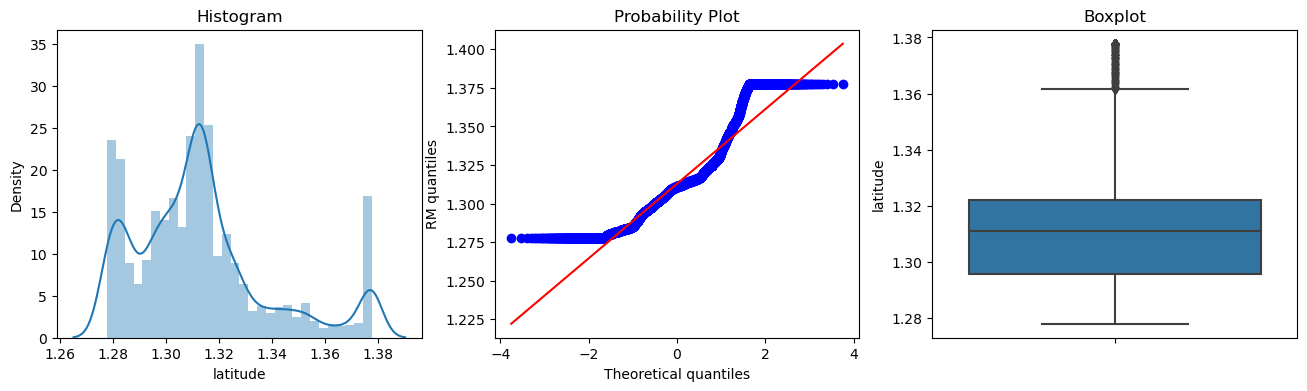

C:\Users\Eng Zhen Ye\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


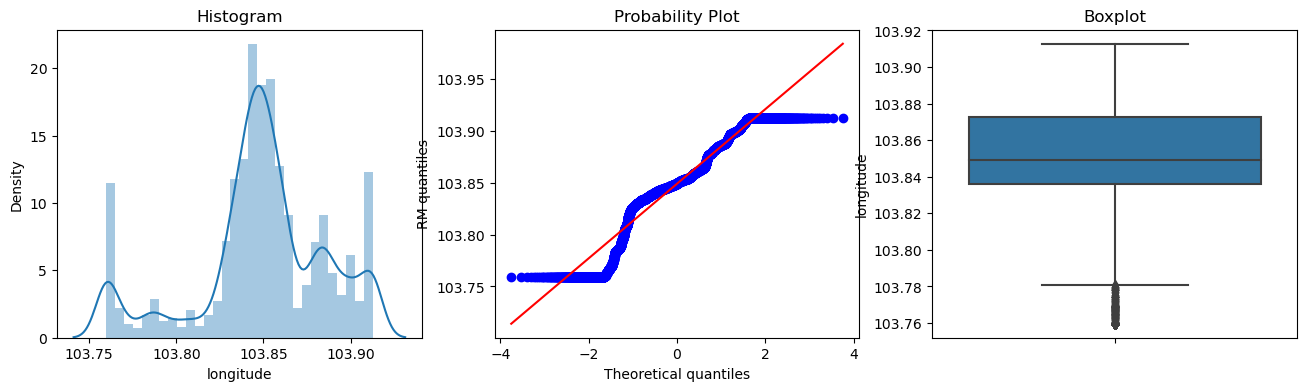

In [83]:
# trimming of distant outliers before transforming
windsorizer = Winsorizer(capping_method ='quantiles', 
                        tail='both', # cap left, right or both tails
                        fold =0.05, # after experimenting with capping methods and folds, this is best
                        variables=['latitude'])

windsorizer.fit(lis)
lis = windsorizer.transform(lis)
diagnostic_plots(lis, 'latitude')

windsorizer = Winsorizer(capping_method ='quantiles', 
                        tail='both', # cap left, right or both tails
                        fold =0.05, # after experimenting with capping methods and folds, this is best
                        variables=['longitude'])

windsorizer.fit(lis)
lis = windsorizer.transform(lis)
diagnostic_plots(lis, 'longitude')

C:\Users\Eng Zhen Ye\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


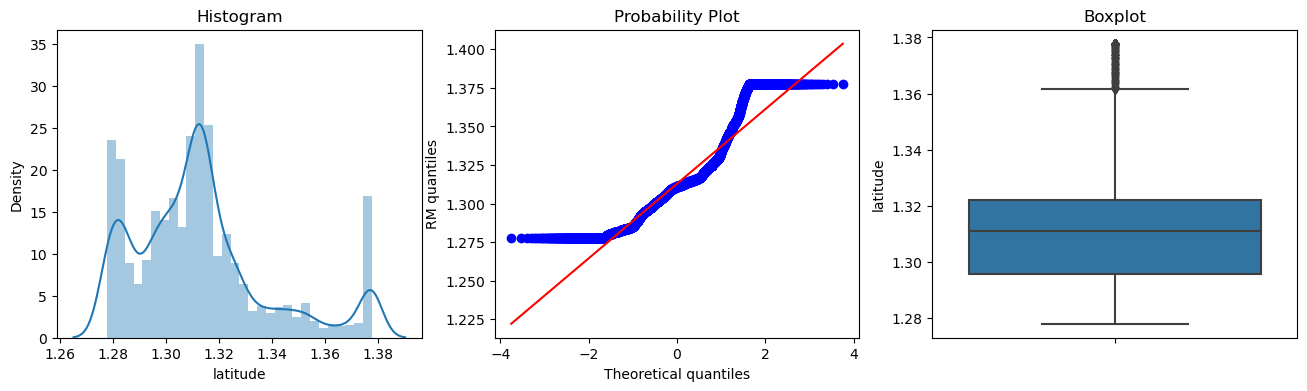

C:\Users\Eng Zhen Ye\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


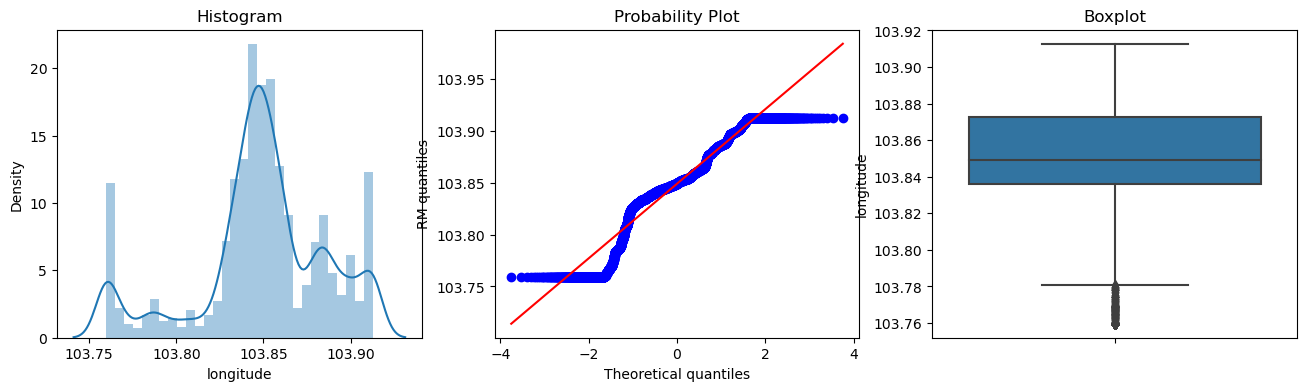

C:\Users\Eng Zhen Ye\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


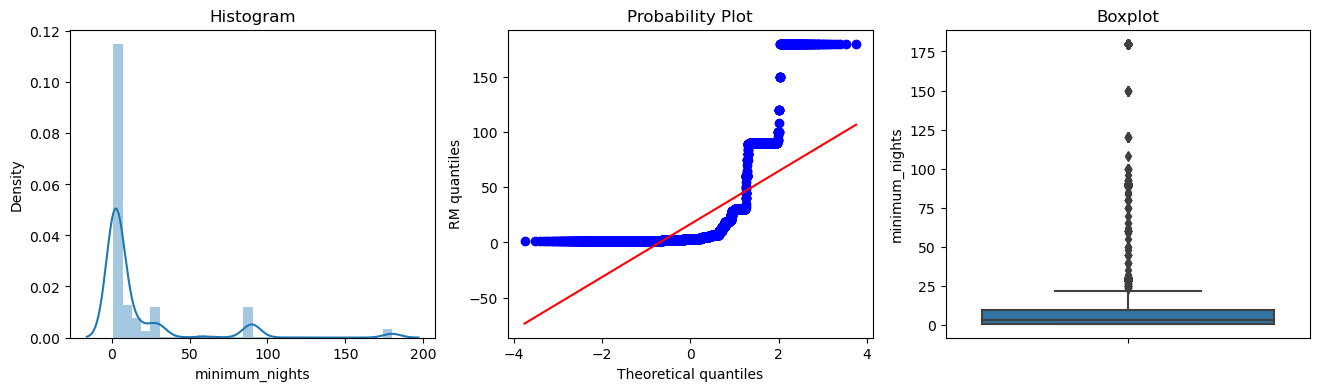

C:\Users\Eng Zhen Ye\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


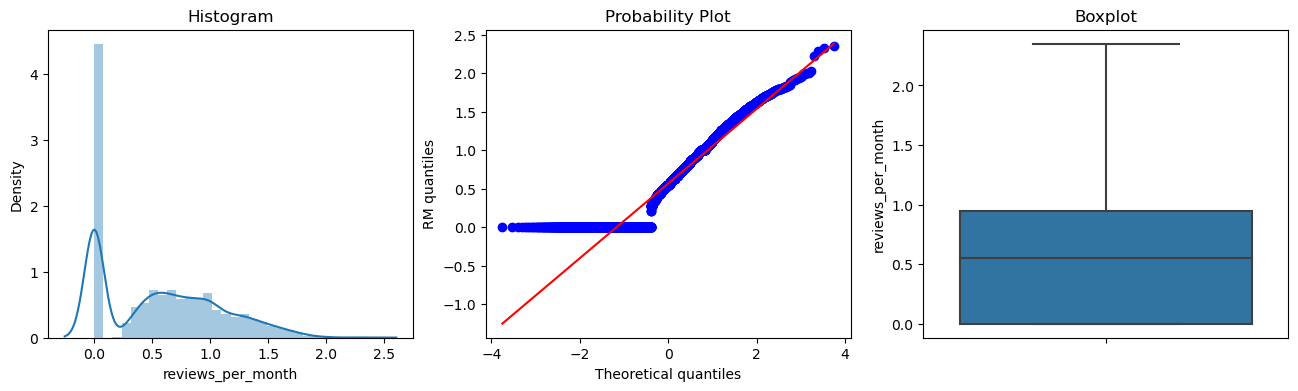

C:\Users\Eng Zhen Ye\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


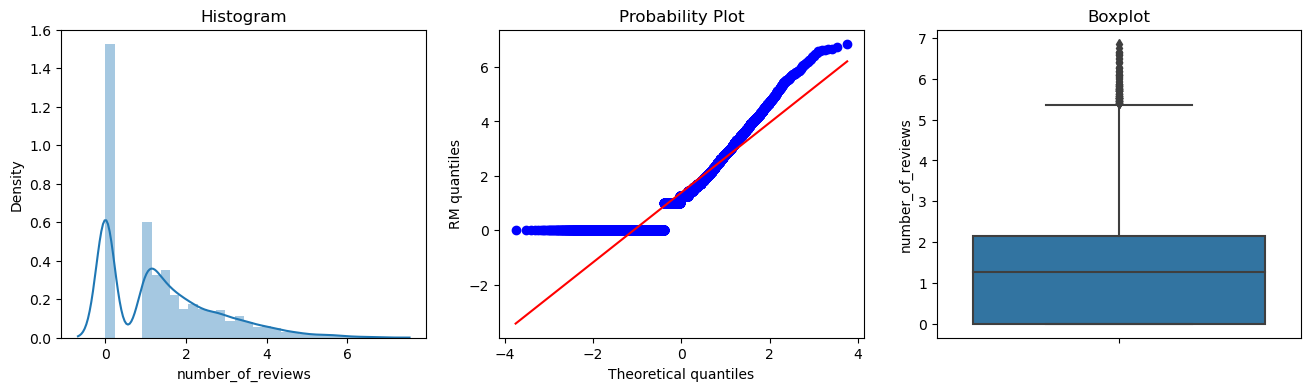

C:\Users\Eng Zhen Ye\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


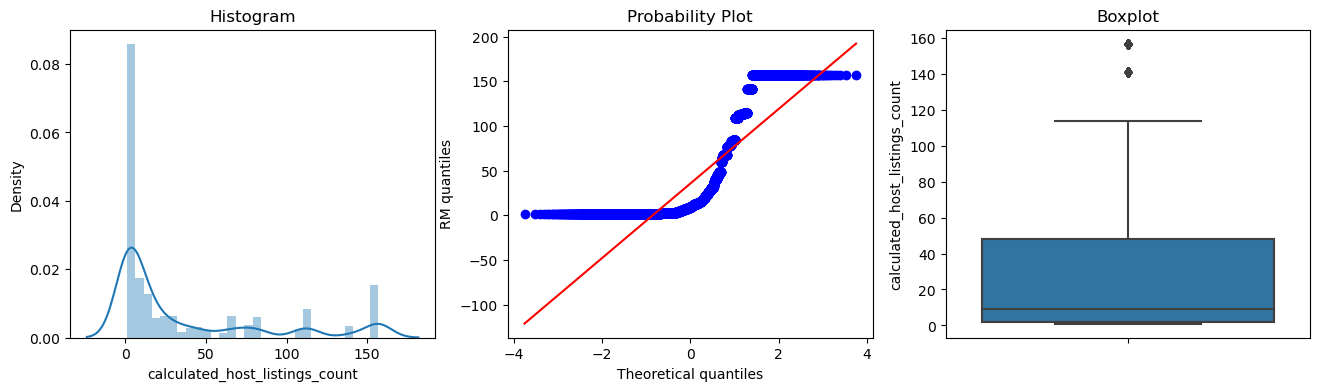

C:\Users\Eng Zhen Ye\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


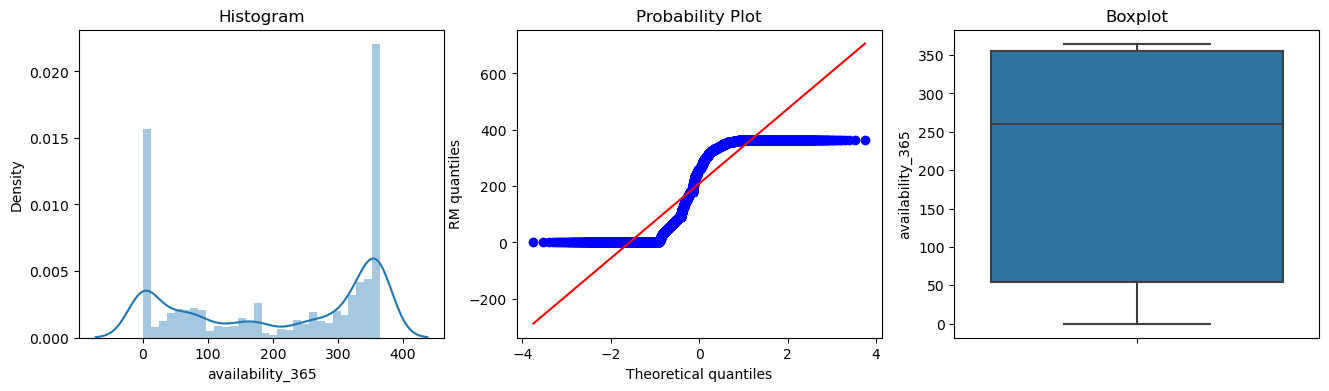

In [84]:
# transform
# latitude, longitude, minimum_nights, number_of_reviews, reviews_per_month, calculated_host_listings_count, availability_365, day, month, year
# LogTransformer
# initialize the transformer
# lt = LogTransformer(variables=[])
# # fit transformer to data set
# lt.fit(lis)
# # transform variables within our data set
# lis_t = lt.transform(lis)

# reciprocal transformer
rt = ReciprocalTransformer(variables = ['latitude', 'longitude'])
# fit transformer to the entire dataframe
rt.fit(lis)
lis_t = rt.transform(lis)

# # BoxCox Transformer
# bct = BoxCoxTransformer(variables = [])
# # fit transformer to the data set
# bct.fit(lis)
# lis_t = bct.transform(lis)

# initialize the transformer with a subset of variables to transform
yjt = YeoJohnsonTransformer(variables = ['calculated_host_listings_count', 'reviews_per_month', 'availability_365', 'minimum_nights'])
# fit transformer to the dataframe
yjt.fit(lis)
# transform indicated variables
lis_t = yjt.transform(lis)

# set up PowerTransformer with the square root exponent
et = PowerTransformer(variables = ['availability_365'], exp=1/2) # for sqr root
# fit transformer to data 
et.fit(lis)
lis_t = et.transform(lis)

# set up PowerTransformer with the cube root exponent
et = PowerTransformer(variables = ['reviews_per_month', 'number_of_reviews'], exp=1/3) # for cube root
# fit transformer to data 
et.fit(lis)
lis_t = et.transform(lis)

diagnostic_plots(lis_t, 'latitude')
diagnostic_plots(lis_t, 'longitude')
diagnostic_plots(lis_t, 'minimum_nights')
diagnostic_plots(lis_t, 'reviews_per_month')
diagnostic_plots(lis_t, 'number_of_reviews')
diagnostic_plots(lis_t, 'calculated_host_listings_count')
diagnostic_plots(lis_t, 'availability_365')

lis = lis_t

~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~

In [85]:
# rare encoder for host_name
def find_frequent_labels(df, variable, tolerance):
    temp = df[variable].value_counts()  / len(df)
    non_rare = [x for x in temp.loc[temp>tolerance].index.values]
    return non_rare

In [86]:
frequent_cat = find_frequent_labels(lis, 'host_name', 0.01)
frequent_cat

['Jay',
 'Alvin',
 'Richards',
 'Aaron',
 'Rain',
 'Darcy',
 'Kaurus',
 'RedDoorz',
 'Alex',
 'Joey']

In [87]:
# grouping rare labels under one category named rare
lis['host_name'] = np.where(lis['host_name'].isin(frequent_cat), lis['host_name'], 'Rare')

In [88]:
# feature engineering

In [89]:
# encoding of categorical data

# Perform one-hot encoding for 'neighbourhood_group'
lis = pd.get_dummies(lis, columns=['neighbourhood_group'], prefix='neigh_group')

# Perform one-hot encoding for 'room_type'
lis = pd.get_dummies(lis, columns=['room_type'], prefix='room_type')

# frequency encoding
lis['neighbourhood'] = lis['neighbourhood'].map(lis['neighbourhood'].value_counts(normalize=True))

# target encoding (used to capture association better)
mean_price = lis.groupby('host_name')['price'].mean()
lis['host_name'] = lis['host_name'].map(mean_price)

lis.head()

id  host_id   host_name  neighbourhood  latitude   longitude  price  \
0  49091   266763  163.753431       0.008479  1.377779  103.795800     83   
1  50646   227796  163.753431       0.016578  1.332350  103.785210     81   
2  56334   266763  163.753431       0.008479  1.377779  103.796670     69   
3  71609   367042  163.753431       0.008099  1.345410  103.912739    206   
4  71896   367042  163.753431       0.008099  1.345670  103.912739     94   

   minimum_nights  number_of_reviews  reviews_per_month  ...  month    year  \
0           180.0           1.000000           0.215443  ...   10.0  2013.0   
1            90.0           2.620741           0.654213  ...   12.0  2014.0   
2             6.0           2.714418           0.584804  ...   10.0  2015.0   
3             1.0           2.410142           0.531329  ...    8.0  2019.0   
4             1.0           2.802039           0.603681  ...    7.0  2019.0   

   neigh_group_Central Region  neigh_group_East Region  \
0                           0                        0   
1                           1                        0   
2                           0                        0   
3                           0                        1   
4                           0                        1   

   neigh_group_North Region  neigh_group_North-East Region  \
0                         1                              0   
1                         0                              0   
2                         1                              0   
3                         0                              0   
4                         0                              0   

   neigh_group_West Region  room_type_Entire home/apt  room_type_Private room  \
0                        0                          0                       1   
1                        0                          0                       1   
2                        0                          0                       1   
3                        0                          0                       1   
4                        0                          0                       1   

   room_type_Shared room  
0                      0  
1                      0  
2                      0  
3                      0  
4                      0  

[5 rows x 23 columns]

~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 

In [90]:
# scaling the data
# Split both Inputs (X) and Ouput (y) into training set (70%) and testing set (30%)

# Define Model Inputs (X) and Output (y)
y = lis["price"]
X = lis.drop('price',axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

# set up the scaler
scaler = StandardScaler()

# fit the scaler to the train set, it will learn the parameters
scaler.fit(X_train)

# transform train and test sets
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

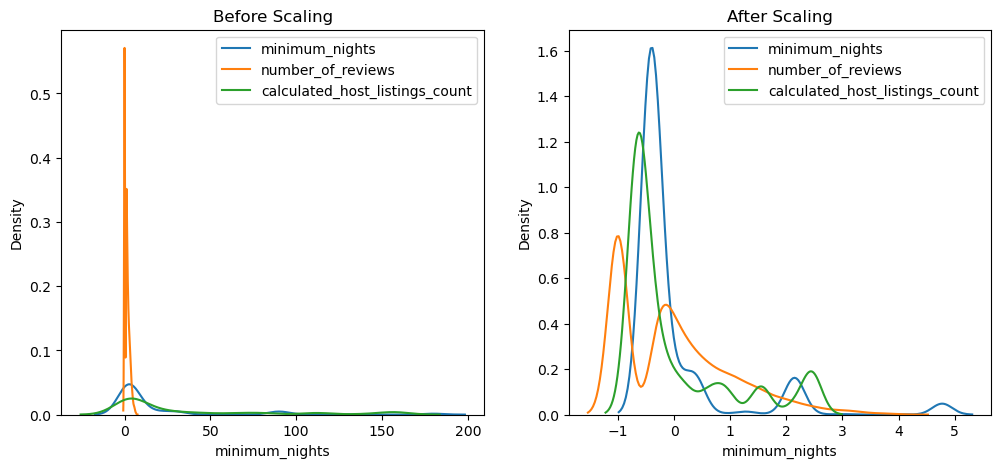

In [91]:
# let's compare the variable distributions before and after scaling
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5))

# before scaling
ax1.set_title('Before Scaling')
sns.kdeplot(X_train['minimum_nights'], ax=ax1, label ='minimum_nights')
sns.kdeplot(X_train['number_of_reviews'], ax=ax1, label ='number_of_reviews')
sns.kdeplot(X_train['calculated_host_listings_count'], ax=ax1, label ='calculated_host_listings_count')
ax1.legend()

# after scaling
ax2.set_title('After Scaling')
sns.kdeplot(X_train_scaled['minimum_nights'], ax=ax2, label ='minimum_nights')
sns.kdeplot(X_train_scaled['number_of_reviews'], ax=ax2, label ='number_of_reviews')
sns.kdeplot(X_train_scaled['calculated_host_listings_count'], ax=ax2, label ='calculated_host_listings_count')
ax2.legend()
plt.show()

In [92]:
# train the model using training set
lm = LinearRegression()
lm.fit(X_train_scaled, y_train)

LinearRegression()

In [93]:
# print out the model coefficients and intercept
print(lm.coef_)
print(lm.intercept_)

[ -8.09879018  -3.77747047   5.97635661  -8.63914686  -6.37436118
  -2.50929254 -15.39046408 -29.20912822  18.87795676 -24.68819076
  21.61563659   0.39854787   4.60201863 -25.05558454   1.17755695
   6.09394252  -4.73746292  -4.30120907  -1.10207796  35.79622098
 -24.90979506 -25.76579944]
163.50985355270237


In [94]:
# Calculated the fitted values for training set
y_fitted = lm.predict(X_train_scaled)

# Calculated the RMSE and R^2 for training set
print(sqrt(mean_squared_error(y_fitted, y_train)), '(Train RMSE)') # RMSE: the lower the better
print(lm.score(X_train_scaled, y_train), '(Train R^2 Value)') # R squared value (ranges from 0 to 1): the higher the better

255.88253388414935 (Train RMSE)
0.0709576477545395 (Train R^2 Value)


In [95]:
# calculated the predicated value for testing data
y_pred = lm.predict(X_test)

# Calculated the RMSE and R^2 for testing set
print(sqrt(mean_squared_error(y_pred, y_test)), '(Test RMSE)') # RMSE: the lower the better
print(lm.score(X_test_scaled, y_test), '(Test R^2 Value)') # R squared value (ranges from 0 to 1): the higher the better

633803791.9426185 (Test RMSE)
0.139965106709807 (Test R^2 Value)


### 2.3 Correlation Analysis

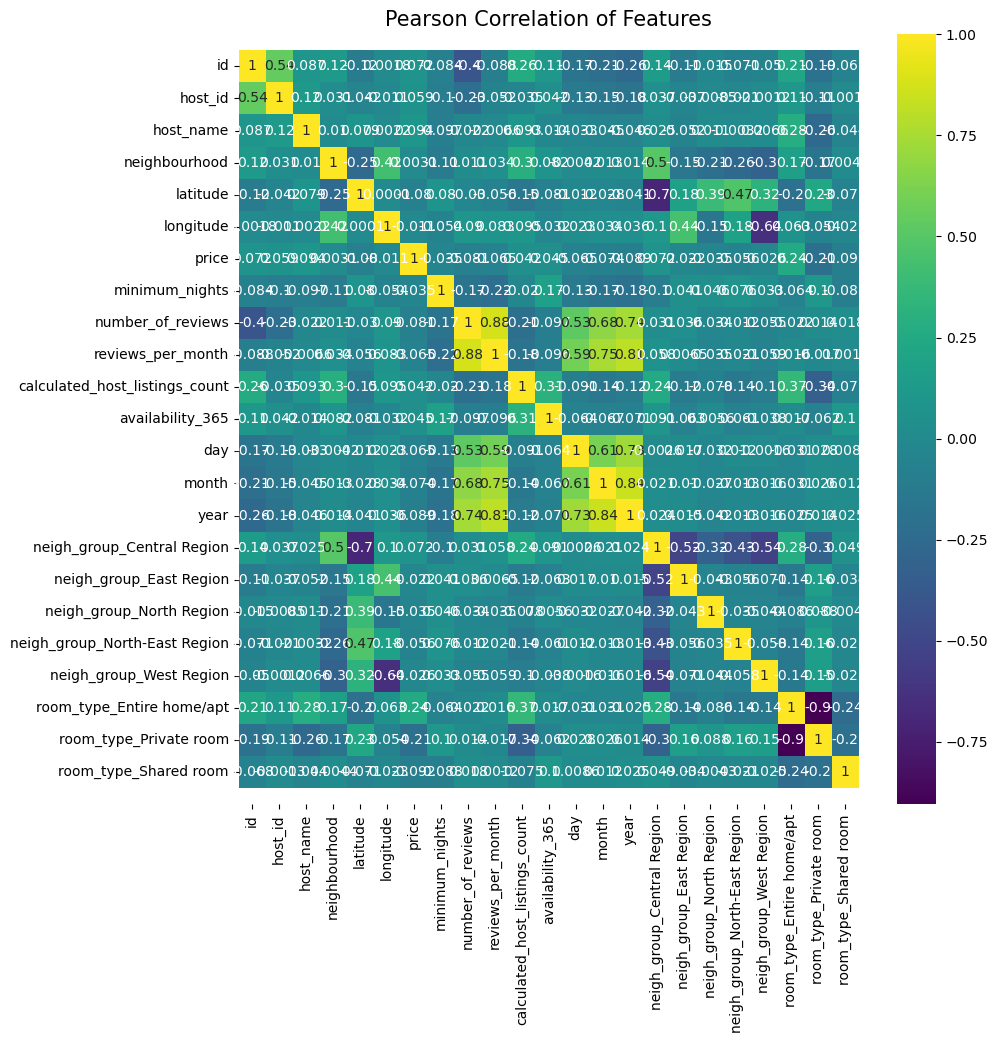

In [96]:
# Heatmap: the correlation between any two features/variables
colormap = plt.cm.viridis
plt.figure(figsize=(10,10))
plt.title('Pearson Correlation of Features', size=15)
ax = sns.heatmap(lis.astype(float).corr(), cmap=colormap, annot=True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

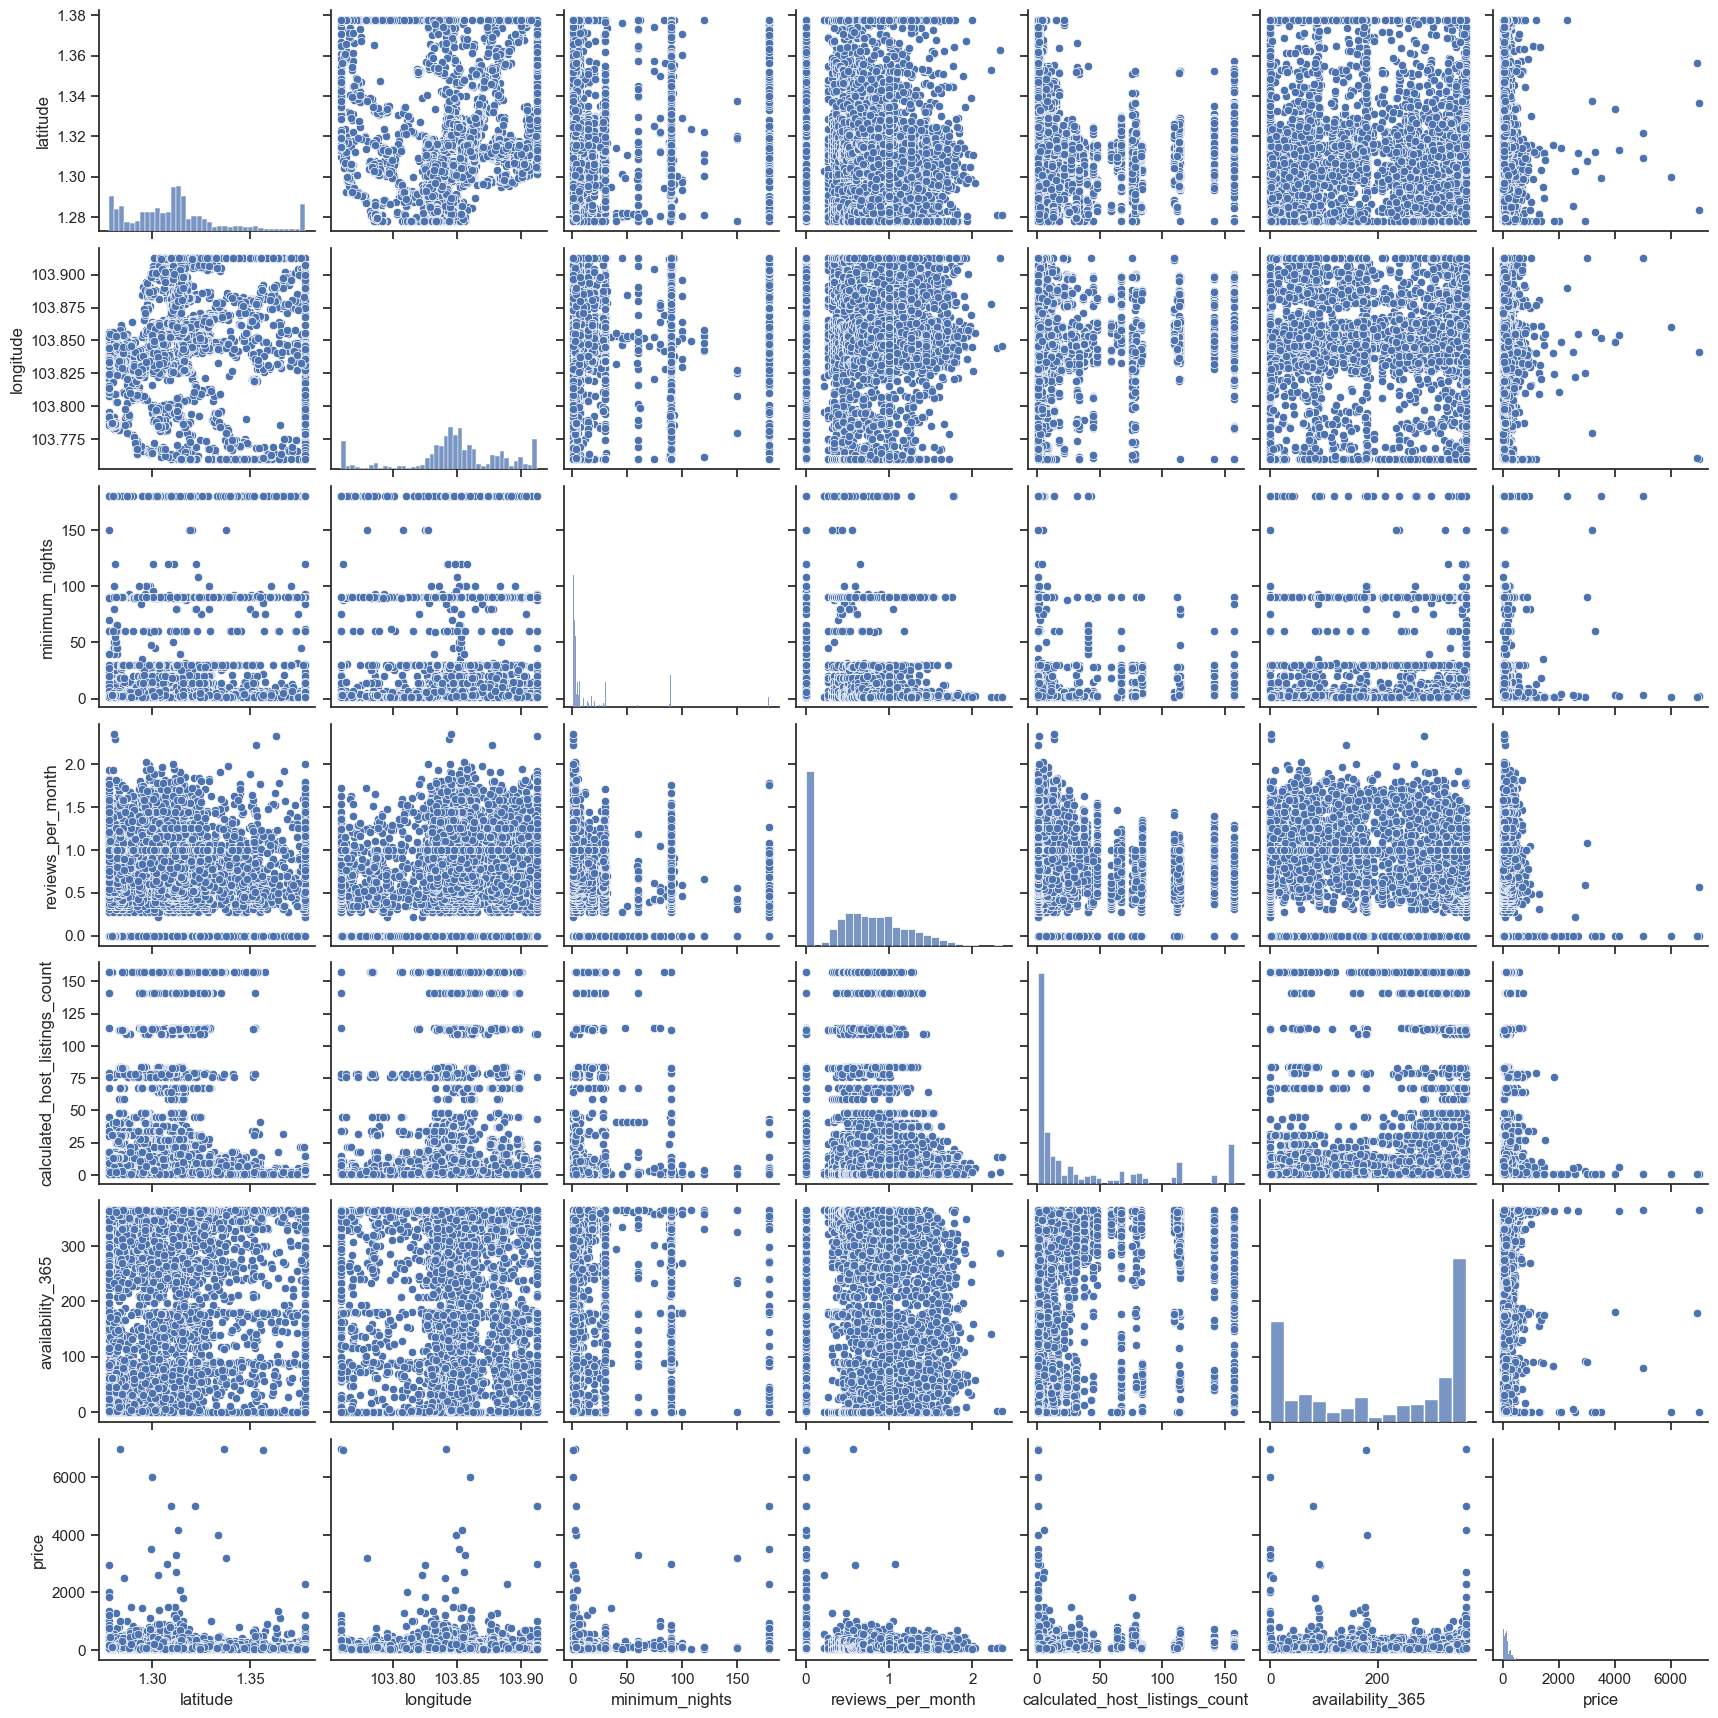

In [97]:
#scatter matrix
sns.set(style="ticks")
sns.pairplot(lis[['latitude', 'longitude', 'minimum_nights', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365', 'price']])

### 2.4 Improving the Model

In [98]:
# The lm model refers to sklearn model and lm2 model refers to statsmodel.api model

# Create another model lm2 using statsmodel.api: the Ordinary Least Squares (OLS) method and fit function
lm2 = sm.OLS(y_train, X_train).fit()
# Summary statistics from the model
lm2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.326
Model:                            OLS   Adj. R-squared (uncentered):              0.324
Method:                 Least Squares   F-statistic:                              127.2
Date:                Sun, 10 Dec 2023   Prob (F-statistic):                        0.00
Time:                        20:28:01   Log-Likelihood:                         -38516.
No. Observations:                5531   AIC:                                  7.707e+04
Df Residuals:                    5510   BIC:                                  7.721e+04
Df Model:                          21                                                  
Covariance Type:            nonrobust                                                  
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
id                             -7.952e-07   5.71e-07     -1.392      0.164   -1.91e-06    3.24e-07
host_id                        -4.589e-08    5.2e-08     -0.882      0.378   -1.48e-07    5.61e-08
host_name                          0.2610      0.161      1.623      0.105      -0.054       0.576
neighbourhood                   -196.3661    114.917     -1.709      0.088    -421.650      28.917
latitude                        -248.7932    225.326     -1.104      0.270    -690.520     192.934
longitude                        -66.8645    185.851     -0.360      0.719    -431.205     297.476
minimum_nights                    -0.4500      0.109     -4.142      0.000      -0.663      -0.237
number_of_reviews                -21.2633      7.271     -2.924      0.003     -35.518      -7.009
reviews_per_month                 36.8209     22.013      1.673      0.094      -6.334      79.976
calculated_host_listings_count    -0.4972      0.087     -5.687      0.000      -0.669      -0.326
availability_365                   0.1478      0.026      5.721      0.000       0.097       0.198
day                                0.0384      0.484      0.079      0.937      -0.910       0.987
month                              1.2106      1.737      0.697      0.486      -2.195       4.616
year                              -0.0260      0.009     -2.912      0.004      -0.043      -0.008
neigh_group_Central Region      2786.0424   7217.609      0.386      0.700   -1.14e+04    1.69e+04
neigh_group_East Region         2808.2563   7230.551      0.388      0.698   -1.14e+04     1.7e+04
neigh_group_North Region        2754.0540   7213.011      0.382      0.703   -1.14e+04    1.69e+04
neigh_group_North-East Region   2762.6153   7225.206      0.382      0.702   -1.14e+04    1.69e+04
neigh_group_West Region         2778.7740   7203.632      0.386      0.700   -1.13e+04    1.69e+04
room_type_Entire home/apt       4734.3247    1.2e+04      0.394      0.694   -1.88e+04    2.83e+04
room_type_Private room          4612.3291    1.2e+04      0.383      0.701    -1.9e+04    2.82e+04
room_type_Shared room           4543.0883    1.2e+04      0.378      0.706    -1.9e+04    2.81e+04
==============================================================================
Omnibus:                    11400.093   Durbin-Watson:                   1.990
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         35790216.793
Skew:                          17.378   Prob(JB):                         0.00
Kurtosis:                     395.546   Cond. No.                     6.93e+23
==============================================================================

Notes:
[1] R² is computed without 

C:\Users\Eng Zhen Ye\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


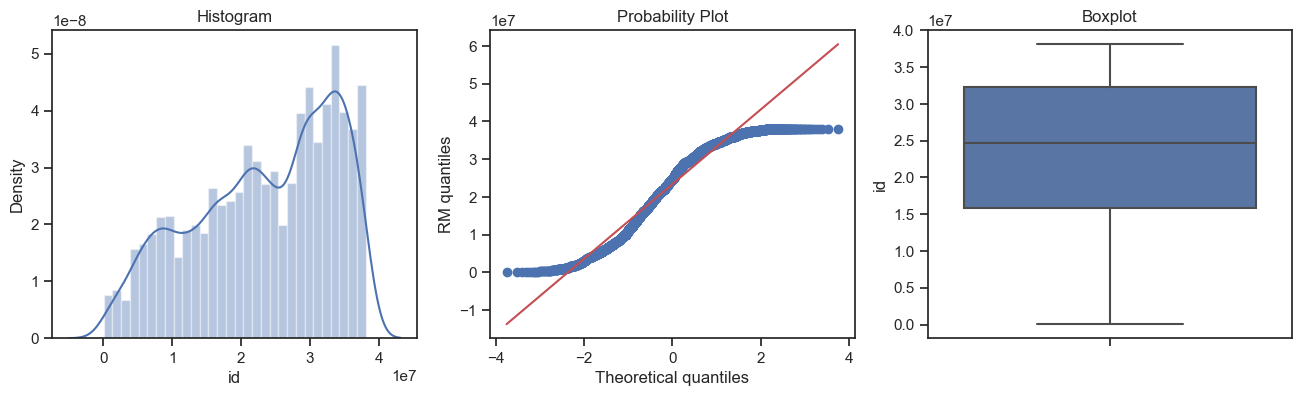

C:\Users\Eng Zhen Ye\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


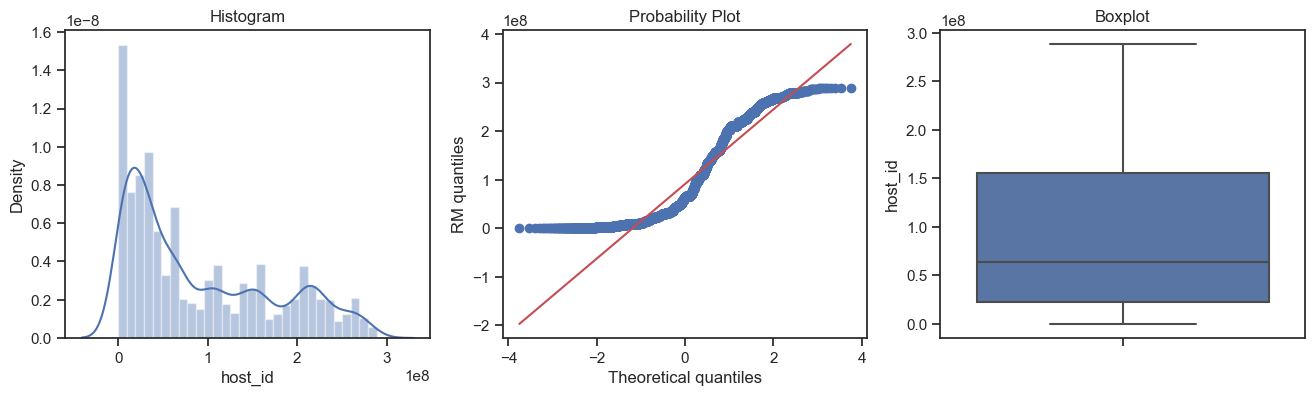

C:\Users\Eng Zhen Ye\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


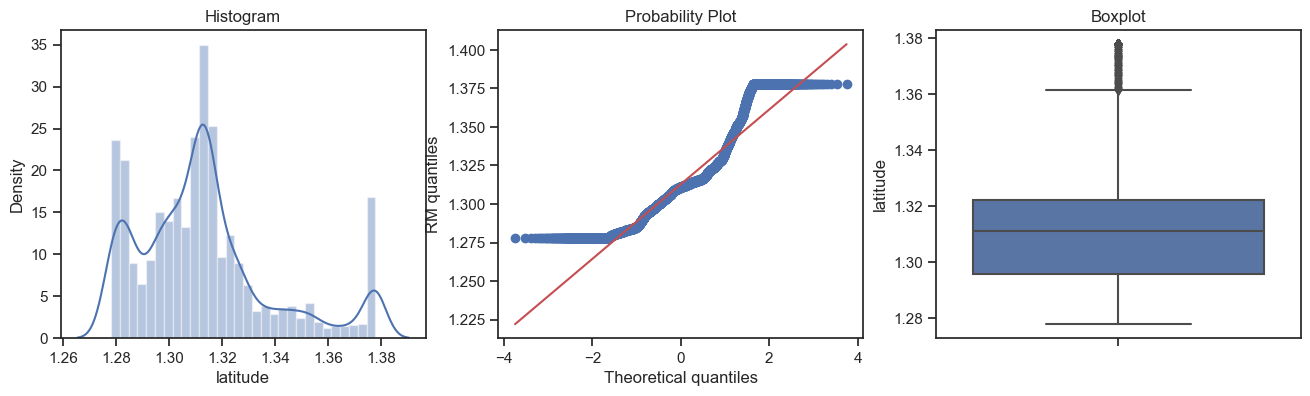

C:\Users\Eng Zhen Ye\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


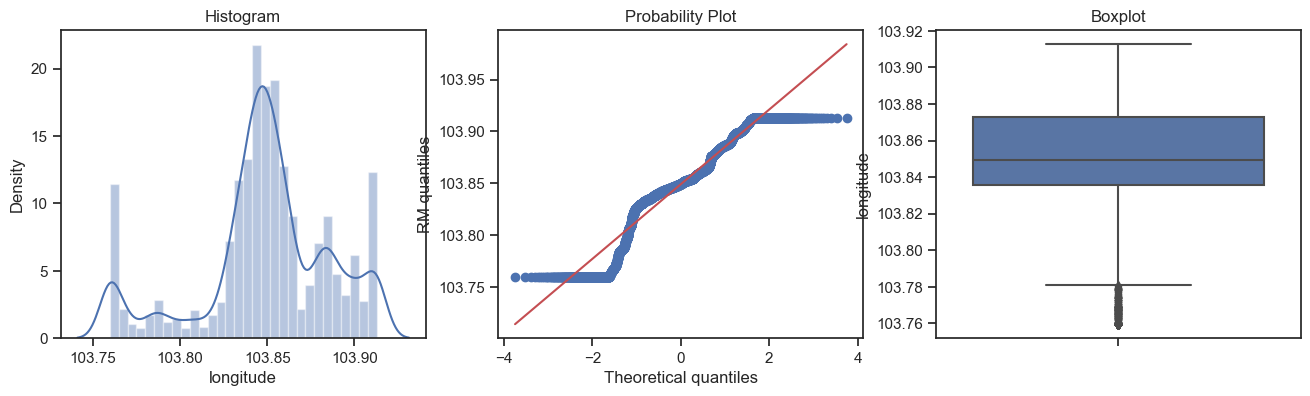

C:\Users\Eng Zhen Ye\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


C:\Users\Eng Zhen Ye\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


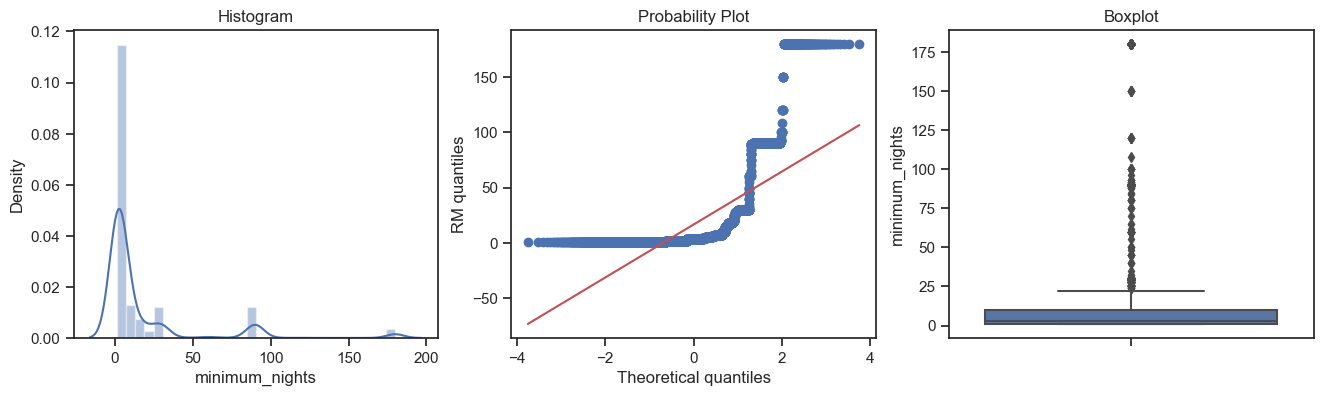

C:\Users\Eng Zhen Ye\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


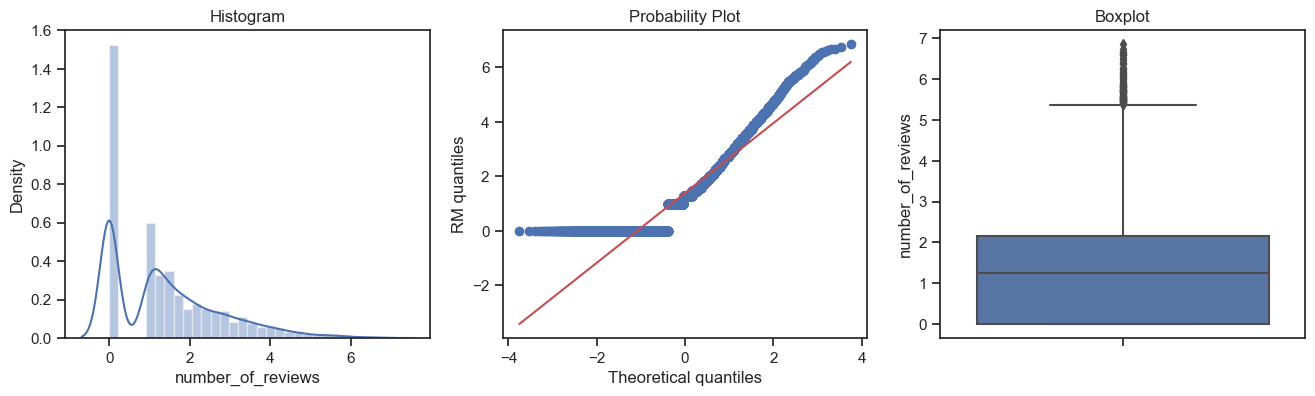

C:\Users\Eng Zhen Ye\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


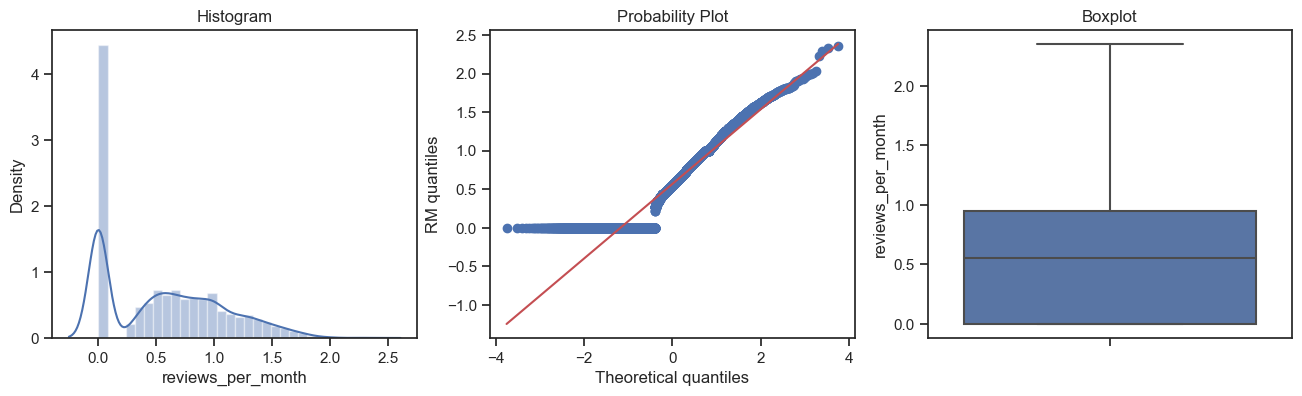

C:\Users\Eng Zhen Ye\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


C:\Users\Eng Zhen Ye\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


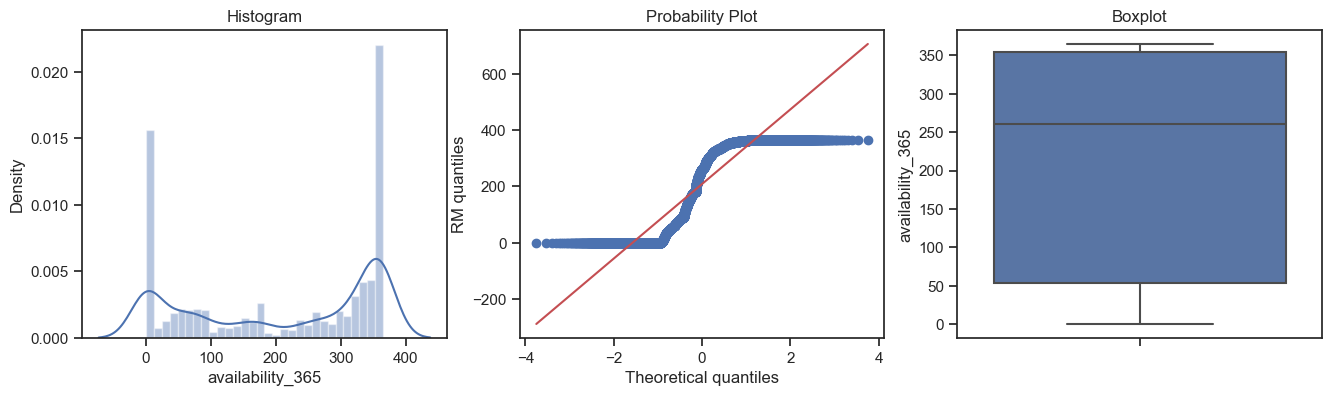

C:\Users\Eng Zhen Ye\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


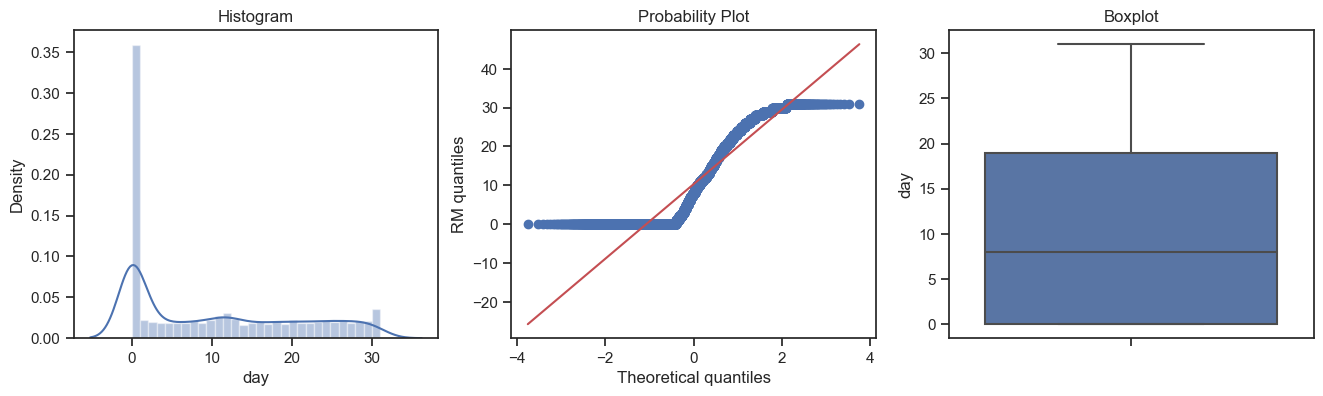

C:\Users\Eng Zhen Ye\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


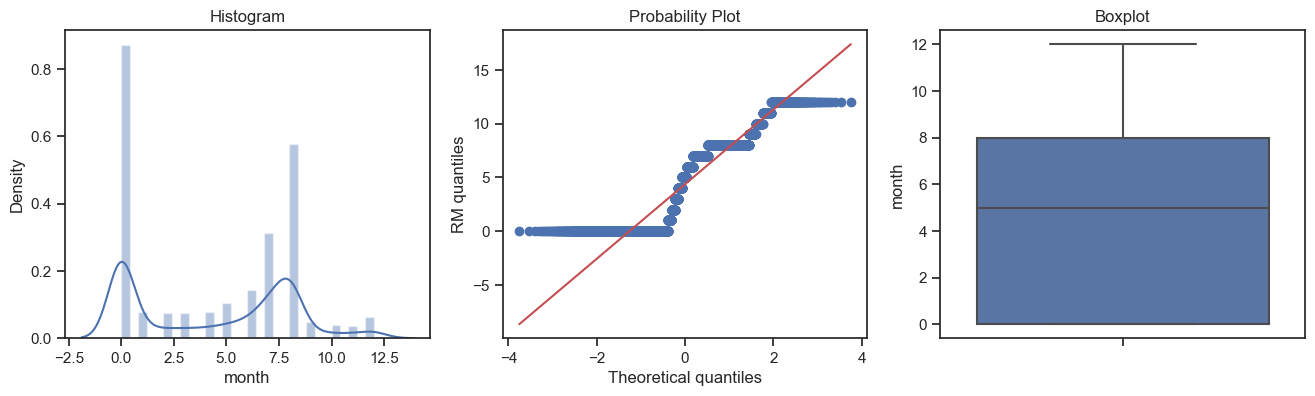

C:\Users\Eng Zhen Ye\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


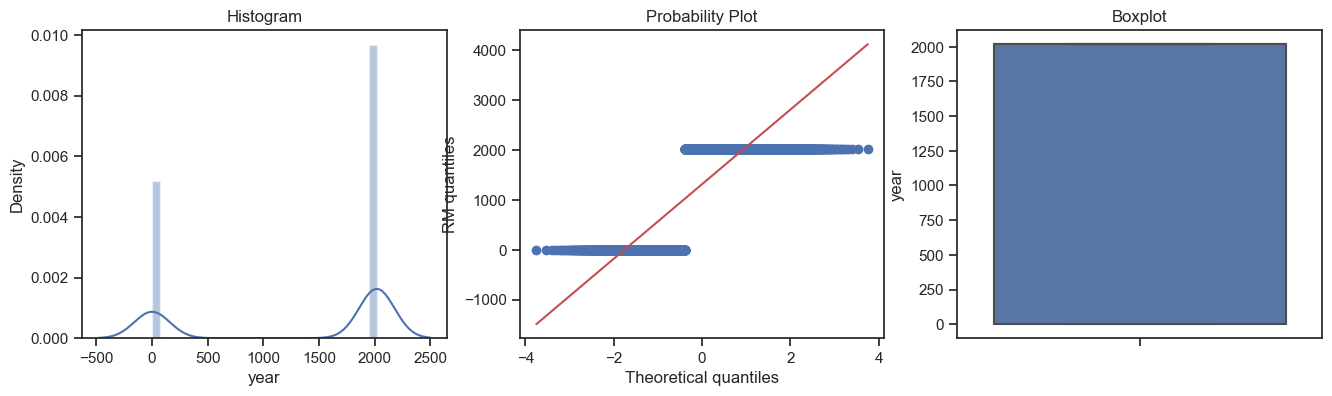

In [99]:
# handling outliers in transformed numerical values by dropping them
lis_save = lis.copy()

# Q-Q plots for applicable numerical columns
for i in numerical_features:
    diagnostic_plots(lis, i)

Number of data points with price over 700: 93
(7800, 23)


C:\Users\Eng Zhen Ye\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


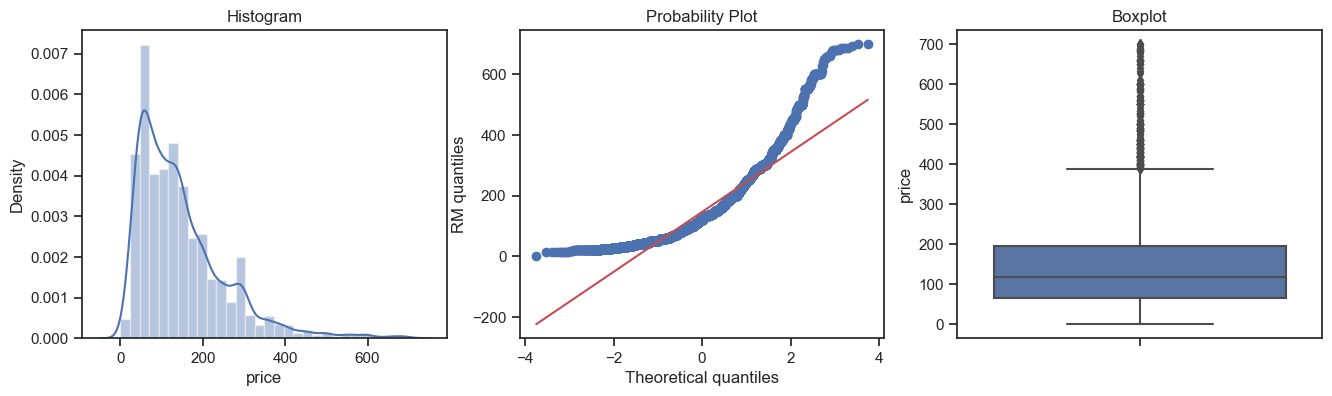

In [100]:
#dropping of some outliers in target (some so as to not remove majority of data) 
count_price_over_700 = (lis['price'] > 700).sum()

print(f"Number of data points with price over 700: {count_price_over_700}")

# only few data points that have these outlier numbers which could skew the data
# filter the dataframe to remove values 700 and above in 'price'
lis = lis[lis['price'] < 700]
print(lis.shape)

diagnostic_plots(lis, 'price')

In [101]:
# replace outliers in reviews_per_month with mean 
# Calculate the first quartile (Q1) and third quartile (Q3)
Q1 = lis['number_of_reviews'].quantile(0.25)
Q3 = lis['number_of_reviews'].quantile(0.75)

# Calculate the interquartile range (IQR)
IQR = Q3 - Q1

# Calculate the lower and upper bounds to identify outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Replace outliers with the mean value
#mean_number_of_reviews = np.mean(lis['number_of_reviews'])
#lis['number_of_reviews'] = np.where((lis['number_of_reviews'] < lower_bound) | (lis['number_of_reviews'] > upper_bound),
#                                    mean_number_of_reviews,
#                                    lis['number_of_reviews'])

#diagnostic_plots(lis, 'number_of_reviews')

In [102]:
# run the model again to get summary and accuracy

# normalizing of data
# Split both Inputs (X) and Ouput (y) into training set (70%) and testing set (30%)

# Define Model Inputs (X) and Output (y)
y = lis["price"]
X = lis.drop('price',axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

# set up the scaler
scaler = StandardScaler()

# fit the scaler to the train set, it will learn the parameters
scaler.fit(X_train)

# transform train and test sets
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

In [103]:
# train the model using training set
lm_i = LinearRegression()
lm_i.fit(X_train_scaled, y_train)

# print out the model coefficients and intercept
print(lm_i.coef_)
print(lm_i.intercept_)

[ -8.28231093   5.99184768   6.29866219  -8.25149788  -7.41382546
   0.52390243 -14.11712014 -20.58976152  17.10610412  -8.85142721
  17.45154123   1.62259927   0.09351577  -9.70618659   2.74343997
   0.11792758  -0.16849611  -2.12192695  -2.63366291  32.1386334
 -22.96050481 -21.53305633]
144.740293040293


In [104]:
# Calculated the fitted values for training set
y_fitted = lm_i.predict(X_train_scaled)

# Calculated the RMSE and R^2 for training set
print(sqrt(mean_squared_error(y_fitted, y_train)), '(Train RMSE)') # RMSE: the lower the better
print(lm_i.score(X_train_scaled, y_train), '(Train R^2 Value)') # R squared value (ranges from 0 to 1): the higher the better

81.78618149707626 (Train RMSE)
0.38658004176866034 (Train R^2 Value)


In [105]:
# calculated the predicated value for testing data
y_pred = lm_i.predict(X_test)

# Calculated the RMSE and R^2 for testing set
print(sqrt(mean_squared_error(y_pred, y_test)), '(Test RMSE)') # RMSE: the lower the better
print(lm_i.score(X_test_scaled, y_test), '(Test R^2 Value)') # R squared value (ranges from 0 to 1): the higher the better

580653533.8211697 (Test RMSE)
0.36106516632844965 (Test R^2 Value)


~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~

(7487, 23)


C:\Users\Eng Zhen Ye\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


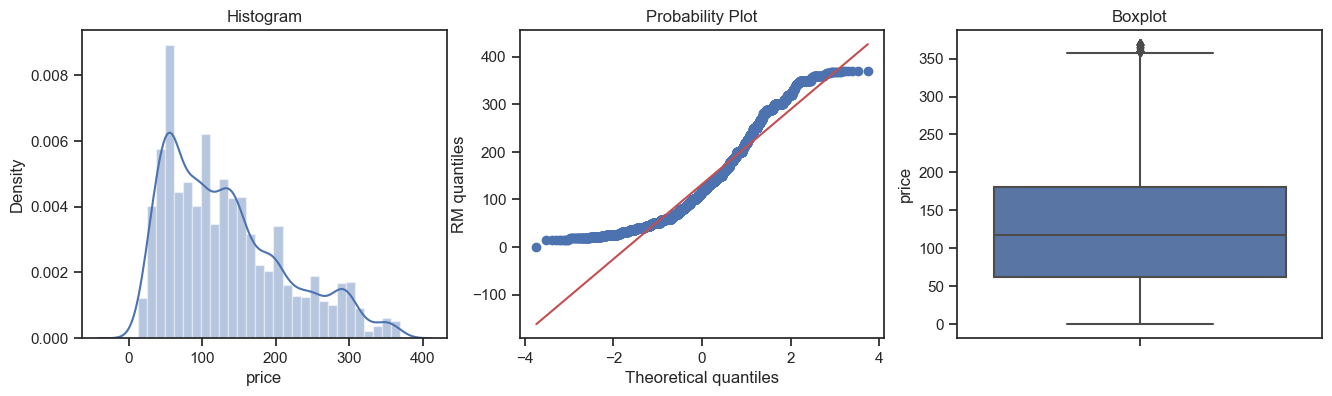

In [106]:
# experiment with straight removing outliers in price
# filter the dataframe to remove values 370 and above in 'price'
lis = lis[lis['price'] < 370]
print(lis.shape)

diagnostic_plots(lis, 'price')

lis_export = lis.copy()

In [107]:
# normalizing of data
# Split both Inputs (X) and Ouput (y) into training set (70%) and testing set (30%)

# Define Model Inputs (X) and Output (y)
y = lis["price"]
X = lis.drop('price',axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

# set up the scaler
scaler = StandardScaler()

# fit the scaler to the train set, it will learn the parameters
scaler.fit(X_train)

# transform train and test sets
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

In [108]:
# train the model using training set
lm_i3 = LinearRegression()
lm_i3.fit(X_train_scaled, y_train)

# print out the model coefficients and intercept
print(lm_i3.coef_)
print(lm_i3.intercept_)

[-9.84732654e+00  4.44469279e+00  8.21198760e+00 -4.29533347e+00
 -4.99505375e+00 -1.84189641e+00 -1.04929557e+01 -1.74283021e+01
  1.37567958e+01 -1.49641232e+00  1.14595063e+01  9.92699841e-02
  2.11634596e-02 -6.03318963e+00  1.84012253e+00  1.65475863e+00
 -1.42566914e+00 -1.37006390e+00 -2.46092133e+00  2.77693346e+01
 -1.93473186e+01 -1.93863754e+01]
131.833015267175


In [109]:
# Calculated the fitted values for training set
y_fitted = lm_i3.predict(X_train_scaled)

# Calculated the RMSE and R^2 for training set
print(sqrt(mean_squared_error(y_fitted, y_train)), '(Train RMSE)') # RMSE: the lower the better
print(lm_i3.score(X_train_scaled, y_train), '(Train R^2 Value)') # R squared value (ranges from 0 to 1): the higher the better

59.15782066940573 (Train RMSE)
0.47222031632454 (Train R^2 Value)


In [110]:
# calculated the predicated value for testing data
y_pred = lm_i3.predict(X_test)

# Calculated the RMSE and R^2 for testing set
print(sqrt(mean_squared_error(y_pred, y_test)), '(Test RMSE)') # RMSE: the lower the better
print(lm_i3.score(X_test_scaled, y_test), '(Test R^2 Value)') # R squared value (ranges from 0 to 1): the higher the better

364616630.2777574 (Test RMSE)
0.4682742276226656 (Test R^2 Value)


In [111]:
# Create another model lm2 using statsmodel.api: the Ordinary Least Squares (OLS) method and fit function
lm_i3_ = sm.OLS(y_train, X_train_scaled).fit()
# Summary statistics from the model
lm_i3_.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.130
Model:                            OLS   Adj. R-squared (uncentered):              0.127
Method:                 Least Squares   F-statistic:                              39.14
Date:                Sun, 10 Dec 2023   Prob (F-statistic):                   7.19e-142
Time:                        20:28:06   Log-Likelihood:                         -33495.
No. Observations:                5240   AIC:                                  6.703e+04
Df Residuals:                    5220   BIC:                                  6.716e+04
Df Model:                          20                                                  
Covariance Type:            nonrobust                                                  
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
id                                -9.8473      3.376     -2.917      0.004     -16.466      -3.229
host_id                            4.4447      2.478      1.794      0.073      -0.412       9.302
host_name                          8.2120      2.138      3.841      0.000       4.021      12.403
neighbourhood                     -4.2953      2.972     -1.445      0.148     -10.122       1.531
latitude                          -4.9951      3.308     -1.510      0.131     -11.480       1.490
longitude                         -1.8419      4.081     -0.451      0.652      -9.842       6.158
minimum_nights                   -10.4930      2.158     -4.863      0.000     -14.723      -6.263
number_of_reviews                -17.4283      5.827     -2.991      0.003     -28.853      -6.004
reviews_per_month                 13.7568      6.584      2.089      0.037       0.849      26.664
calculated_host_listings_count    -1.4964      2.535     -0.590      0.555      -6.466       3.473
availability_365                  11.4595      2.200      5.210      0.000       7.147      15.772
day                                0.0993      2.916      0.034      0.973      -5.617       5.816
month                              0.0212      3.832      0.006      0.996      -7.491       7.533
year                              -6.0332      5.029     -1.200      0.230     -15.893       3.827
neigh_group_Central Region         1.8401      1.922      0.957      0.338      -1.928       5.609
neigh_group_East Region            1.6548      2.498      0.662      0.508      -3.242       6.552
neigh_group_North Region          -1.4257      2.207     -0.646      0.518      -5.753       2.902
neigh_group_North-East Region     -1.3701      2.348     -0.584      0.560      -5.973       3.233
neigh_group_West Region           -2.4609      2.777     -0.886      0.376      -7.905       2.983
room_type_Entire home/apt         27.7693      1.280     21.696      0.000      25.260      30.279
room_type_Private room           -19.3473      1.262    -15.335      0.000     -21.821     -16.874
room_type_Shared room            -19.3864      1.877    -10.327      0.000     -23.067     -15.706
==============================================================================
Omnibus:                      755.999   Durbin-Watson:                   0.335
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1198.233
Skew:                           0.998   Prob(JB):                    6.41e-261
Kurtosis:                       4.225   Cond. No.                     4.46e+15
==============================================================================

Notes:
[1] R² is computed without 

~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~

In [112]:
# lis = lis_save.copy()
lis_save = lis.copy()
# drop features
# dropping gender and recruitment_channel
lis.drop(columns=['neighbourhood', 'latitude','longitude', 'calculated_host_listings_count', 'month', 'day', 'year', 'neigh_group_Central Region', 'neigh_group_East Region', 'neigh_group_North Region', 'neigh_group_North-East Region', 'neigh_group_West Region'], inplace=True)
# lis.drop(columns=['day'], inplace=True)
# lis_export = lis.copy()

In [113]:
# normalizing of data
# Split both Inputs (X) and Ouput (y) into training set (70%) and testing set (30%)

# Define Model Inputs (X) and Output (y)
y = lis["price"]
X = lis.drop('price',axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

# set up the scaler
scaler = StandardScaler()

# fit the scaler to the train set, it will learn the parameters
scaler.fit(X_train)

# transform train and test sets
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

In [114]:
# train the model using training set
lm_i4 = LinearRegression()
lm_i4.fit(X_train_scaled, y_train)

# print out the model coefficients and intercept
print(lm_i4.coef_)
print(lm_i4.intercept_)

[ -8.26448399   5.12543332   7.60147179  -9.97042911 -15.1881617
   7.82279196  10.92375558  27.91698539 -19.77321978 -18.76083888]
131.83301526717557


In [115]:
# Calculated the fitted values for training set
y_fitted = lm_i4.predict(X_train_scaled)

# Calculated the RMSE and R^2 for training set
print(sqrt(mean_squared_error(y_fitted, y_train)), '(Train RMSE)') # RMSE: the lower the better
print(lm_i4.score(X_train_scaled, y_train), '(Train R^2 Value)') # R squared value (ranges from 0 to 1): the higher the better

59.79537334267086 (Train RMSE)
0.4607830952906794 (Train R^2 Value)


In [116]:
# calculated the predicated value for testing data
y_pred = lm_i4.predict(X_test)

# Calculated the RMSE and R^2 for testing set
print(sqrt(mean_squared_error(y_pred, y_test)), '(Test RMSE)') # RMSE: the lower the better
print(lm_i4.score(X_test_scaled, y_test), '(Test R^2 Value)') # R squared value (ranges from 0 to 1): the higher the better

467695629.4444017 (Test RMSE)
0.45266146667311724 (Test R^2 Value)


~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~

### experiment PCA

In [117]:
from sklearn.decomposition import PCA
# the lis_save is the version of the dataset

# Define Model Inputs (X) and Output (y)
y = lis_save["price"]
X = lis_save.drop('price',axis=1)

# set up the PCA
pca = PCA()

# set up the scaler
scaler = StandardScaler()

# fit the scaler to the train set, it will learn the parameters
scaler.fit(X)

# transform train and test sets
X_scaled = scaler.transform(X)

pca.fit(X_scaled)
#X_new = pca.transform(X_scaled)

PCA()

Text(0, 0.5, 'Percentage of Variance Explained')

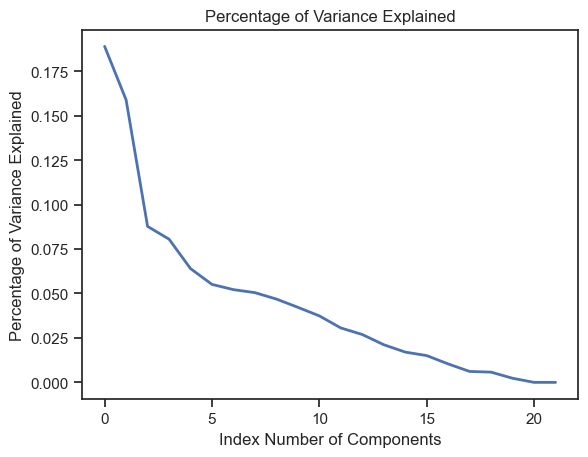

In [118]:
plt.plot(pca.explained_variance_ratio_, linewidth=2)
plt.title('Percentage of Variance Explained')
plt.xlabel('Index Number of Components')
plt.ylabel('Percentage of Variance Explained')

In [119]:
# show the variance explanation for each Principal Component
print(len(pca.explained_variance_ratio_))
print(pca.explained_variance_ratio_)


22
[1.89033056e-01 1.58943876e-01 8.77503941e-02 8.05767326e-02
 6.40127328e-02 5.51128785e-02 5.21754168e-02 5.04754056e-02
 4.68675331e-02 4.22248854e-02 3.74108666e-02 3.06146380e-02
 2.69285869e-02 2.11850452e-02 1.70370398e-02 1.50713864e-02
 1.03651501e-02 6.14856684e-03 5.75677984e-03 2.30902959e-03
 1.96882855e-33 7.18254105e-34]


In [120]:
# Explained variance ratios obtained from PCA
explained_variance_ratios = np.array([1.89033056e-01, 1.58943876e-01, 8.77503941e-02, 8.05767326e-02,
 6.40127328e-02, 5.51128785e-02, 5.21754168e-02, 5.04754056e-02,
 4.68675331e-02, 4.22248854e-02, 3.74108666e-02, 3.06146380e-02,
 2.69285869e-02, 2.11850452e-02, 1.70370398e-02, 1.50713864e-02,
 1.03651501e-02, 6.14856684e-03, 5.75677984e-03, 2.30902959e-03,
 1.96882855e-33, 7.18254105e-34])

# Find the number of components that contribute to 90% of variance
cumulative_variance = np.cumsum(explained_variance_ratios)
n_components = np.argmax(cumulative_variance >= 1) + 1  # Adding 1 to start indexing from 1

print(f"Number of components contributing to 100% variance: {n_components}")

Number of components contributing to 100% variance: 20


In [121]:
pca = PCA(n_components=n_components) # reinstantiate pca to use the features that variance adds up to 1
pca.fit(X_scaled)
X_new = pca.transform(X_scaled)

In [122]:
X_new = pd.DataFrame(X_new, index=X.index)

X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.3, random_state=1)

# set up the scaler
scaler = StandardScaler()

# fit the scaler to the train set, it will learn the parameters
scaler.fit(X_train)

# transform train and test sets
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

In [123]:
# train the model using training set
lmp = LinearRegression()
lmp.fit(X_train_scaled, y_train)

# print out the model coefficients and intercept
print(lmp.coef_)
print(lmp.intercept_)

[-14.44251069 -34.01293009  21.19526464  25.1860255   11.31724968
  -8.26908299  -9.94629624   0.18737988   1.17785615   5.86096913
  -0.66437711 -10.51641542 -10.42572356 -11.9472317    2.72415306
  -2.59411085  -0.35574454  -0.26417294  -0.1374194    5.60816453]
131.83301526717557


In [124]:
# Calculated the fitted values for training set
y_fitted = lmp.predict(X_train_scaled)

# Calculated the RMSE and R^2 for training set
print(sqrt(mean_squared_error(y_fitted, y_train)), '(Train RMSE)') # RMSE: the lower the better
print(lmp.score(X_train_scaled, y_train), '(Train R^2 Value)') # R squared value (ranges from 0 to 1): the higher the better

59.15782066940573 (Train RMSE)
0.47222031632454 (Train R^2 Value)


In [125]:
# calculated the predicated value for testing data
y_pred = lmp.predict(X_test)

# Calculated the RMSE and R^2 for testing set
print(sqrt(mean_squared_error(y_pred, y_test)), '(Test RMSE)') # RMSE: the lower the better
print(lmp.score(X_test_scaled, y_test), '(Test R^2 Value)') # R squared value (ranges from 0 to 1): the higher the better

69.65463690376622 (Test RMSE)
0.4682742276226656 (Test R^2 Value)


In [126]:
# Concatenate scaled features and target variables
train_data = pd.concat([X_train_scaled, y_train.reset_index(drop=True)], axis=1)
test_data = pd.concat([X_test_scaled, y_test.reset_index(drop=True)], axis=1)

# Combine train and test data
lis_export = pd.concat([train_data, test_data], ignore_index=True)

### 2.5 Export the data

In [127]:
lis_export.to_csv('C:/Users/Eng Zhen Ye/ML/asg 1/lis_export.csv', index=False)